# Face Recognition Multi-Model Training on LFW - PART 1
## Training Multiple Models with Deep Learning Backbones and Classical/Neural Classifier Heads

This notebook trains multiple face identification models and compares their performance.
- **Task**: Face Identification (multi-class classification)
- **Backbones (Part 1)**: ResNet50, EfficientNet-B0, DenseNet121, MobileNet-V3
- **Neural Heads**: Simple, MLP, Deep, Attention, CosFace
- **Classical Classifiers**: SVM (RBF & Linear), Random Forest, XGBoost
- **Output**: Best model for video face recognition + JSON results file
- **Hardware**: Optimized for Kaggle 2x Tesla T4 GPU with DataParallel support
- **Epochs**: 10 per model

In [1]:
import os
import gc
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from pathlib import Path
from tqdm.auto import tqdm
import json
import time
import joblib
from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR

import torchvision.transforms as transforms
from torchvision import models

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             confusion_matrix, classification_report, top_k_accuracy_score,
                             roc_auc_score, roc_curve, auc, log_loss)

# Optional XGBoost
try:
    import xgboost as xgb
    HAS_XGB = True
    print("✓ XGBoost available")
except ImportError:
    HAS_XGB = False
    print("✗ XGBoost not available - will skip XGBoost classifiers")

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ============================================================
# GPU SETUP - OPTIMIZED FOR 2x TESLA T4
# ============================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_gpus = torch.cuda.device_count()

print(f"\n{'='*60}")
print("HARDWARE CONFIGURATION")
print(f"{'='*60}")
print(f"Device: {device}")
print(f"Number of GPUs: {n_gpus}")

if n_gpus > 0:
    for i in range(n_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        gpu_memory = torch.cuda.get_device_properties(i).total_memory / 1e9
        print(f"  GPU {i}: {gpu_name} ({gpu_memory:.1f} GB)")
        
        # Check if Tesla T4 for optimized settings
        if 'T4' in gpu_name:
            print(f"    → Tesla T4 detected! Using optimized settings.")
            torch.backends.cudnn.benchmark = True  # Enable for T4 optimization

print(f"{'='*60}")

✓ XGBoost available

HARDWARE CONFIGURATION
Device: cuda
Number of GPUs: 2
  GPU 0: Tesla T4 (15.6 GB)
    → Tesla T4 detected! Using optimized settings.
  GPU 1: Tesla T4 (15.6 GB)
    → Tesla T4 detected! Using optimized settings.


In [2]:
# ============================================================
# KAGGLE CONFIGURATION
# ============================================================
# Set this to True when running on Kaggle
RUNNING_ON_KAGGLE = True

if RUNNING_ON_KAGGLE:
    # Data is already extracted on Kaggle at this path
    DATA_DIR = '/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'
    WORK_DIR = '/kaggle/working'
    MODELS_DIR = os.path.join(WORK_DIR, 'models_part1')
else:
    # Local paths
    WORK_DIR = '../outputs'
    DATA_DIR = '../data/lfw-deepfunneled/lfw-deepfunneled'
    MODELS_DIR = '../models/checkpoints_part1'

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(WORK_DIR, exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Working directory: {WORK_DIR}")
print(f"Models directory: {MODELS_DIR}")

Data directory: /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled
Working directory: /kaggle/working
Models directory: /kaggle/working/models_part1


In [3]:
# Verify data exists
if os.path.exists(DATA_DIR):
    num_people = len([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
    print(f"✓ Data found at {DATA_DIR}")
    print(f"  Total people directories: {num_people}")
else:
    raise FileNotFoundError(f"Data not found at {DATA_DIR}. Please check the path.")

✓ Data found at /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled
  Total people directories: 5749


## 1. Data Loading and Preprocessing

In [4]:
# Configuration
MIN_IMAGES_PER_PERSON = 10  # Only include people with >= N images
MAX_PEOPLE = 100  # Limit to top N people (None for all)
VAL_SPLIT = 0.2
IMG_SIZE = 224
BATCH_SIZE = 32 * max(1, n_gpus)  # Scale batch size with GPUs

print(f"Batch size: {BATCH_SIZE}")
print(f"Min images per person: {MIN_IMAGES_PER_PERSON}")
print(f"Max people: {MAX_PEOPLE}")

Batch size: 64
Min images per person: 10
Max people: 100


In [5]:
def load_lfw_dataset(data_dir, min_images=10, max_people=None):
    """Load LFW dataset for face identification."""
    people_dirs = sorted([d for d in os.listdir(data_dir) 
                          if os.path.isdir(os.path.join(data_dir, d))])
    
    # Count images per person
    person_counts = {}
    for person in people_dirs:
        person_path = os.path.join(data_dir, person)
        images = [f for f in os.listdir(person_path) if f.endswith('.jpg')]
        if len(images) >= min_images:
            person_counts[person] = len(images)
    
    # Sort by count and limit
    sorted_people = sorted(person_counts.items(), key=lambda x: x[1], reverse=True)
    if max_people:
        sorted_people = sorted_people[:max_people]
    
    # Create class mapping
    class_names = [p[0] for p in sorted_people]
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}
    
    # Collect all image paths and labels
    image_paths = []
    labels = []
    
    for person in class_names:
        person_path = os.path.join(data_dir, person)
        images = [f for f in os.listdir(person_path) if f.endswith('.jpg')]
        for img in images:
            image_paths.append(os.path.join(person_path, img))
            labels.append(class_to_idx[person])
    
    return image_paths, labels, class_names

# Load dataset
image_paths, labels, class_names = load_lfw_dataset(
    DATA_DIR, 
    min_images=MIN_IMAGES_PER_PERSON,
    max_people=MAX_PEOPLE
)

num_classes = len(class_names)
print(f"\nTotal images: {len(image_paths)}")
print(f"Number of classes (people): {num_classes}")
print(f"\nFirst 10 people: {class_names[:10]}")


Total images: 3651
Number of classes (people): 100

First 10 people: ['George_W_Bush', 'Colin_Powell', 'Tony_Blair', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'Ariel_Sharon', 'Hugo_Chavez', 'Junichiro_Koizumi', 'Jean_Chretien', 'John_Ashcroft']


In [6]:
# Train/Val split
X_train, X_val, y_train, y_val = train_test_split(
    image_paths, labels, 
    test_size=VAL_SPLIT, 
    stratify=labels, 
    random_state=SEED
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

Training samples: 2920
Validation samples: 731


In [7]:
# Dataset class
class FaceDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

# Transforms - EXACT SAME AS REFERENCE
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = FaceDataset(X_train, y_train, transform=train_transform)
val_dataset = FaceDataset(X_val, y_val, transform=val_transform)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
    num_workers=4, pin_memory=True, drop_last=True
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=4, pin_memory=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 45
Val batches: 12


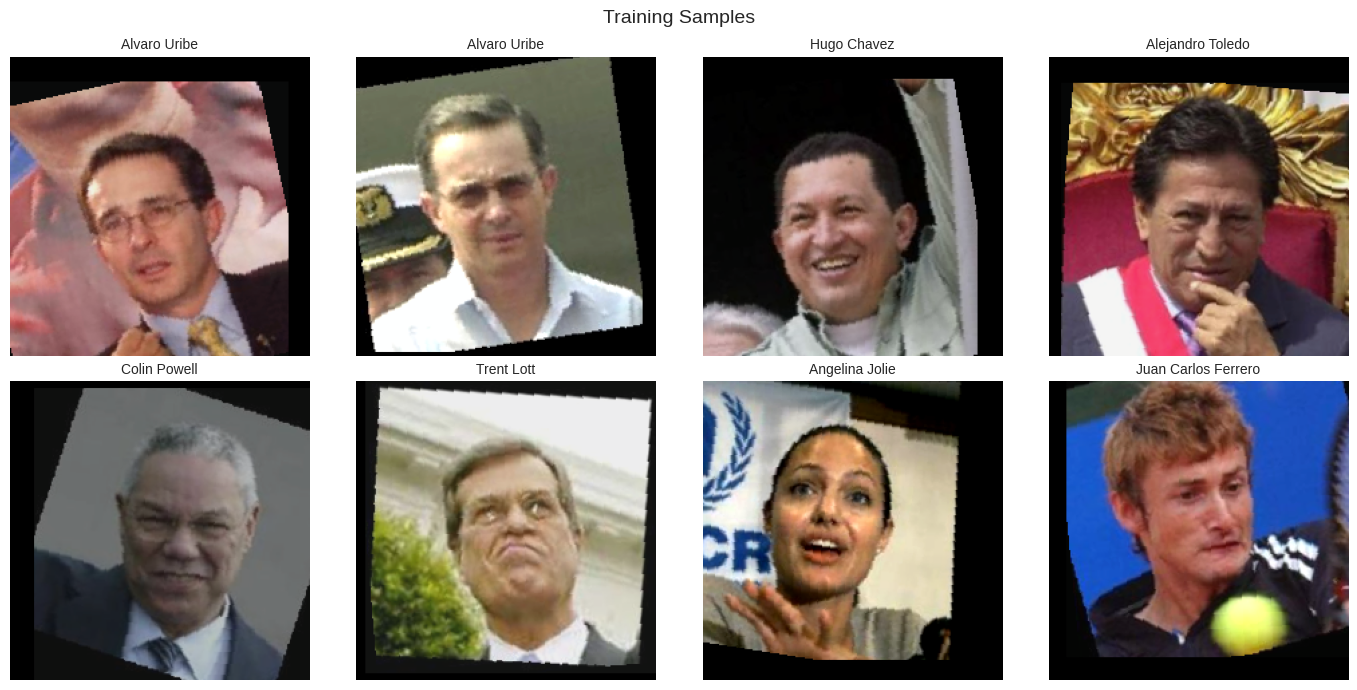

In [8]:
# Visualize samples
def show_samples(dataset, class_names, n=8):
    fig, axes = plt.subplots(2, 4, figsize=(14, 7))
    indices = np.random.choice(len(dataset), n, replace=False)
    
    for i, ax in enumerate(axes.flat):
        img, label = dataset[indices[i]]
        img = img.permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        ax.set_title(class_names[label].replace('_', ' '), fontsize=10)
        ax.axis('off')
    
    plt.suptitle('Training Samples', fontsize=14)
    plt.tight_layout()
    plt.show()

show_samples(train_dataset, class_names)

## 2. Model Architectures

In [9]:
# ============================================================
# BACKBONE DEFINITIONS - PART 1
# ResNet50, EfficientNet-B0, DenseNet121, MobileNet-V3
# ============================================================

def get_backbone(name, pretrained=True):
    """Get backbone network with pretrained weights."""
    if name == 'resnet50':
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)
        out_features = model.fc.in_features
        model.fc = nn.Identity()
        
    elif name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None)
        out_features = model.classifier[1].in_features
        model.classifier = nn.Identity()
        
    elif name == 'densenet121':
        model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None)
        out_features = model.classifier.in_features
        model.classifier = nn.Identity()
        
    elif name == 'mobilenet_v3':
        model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V2 if pretrained else None)
        out_features = model.classifier[0].in_features
        model.classifier = nn.Identity()
        
    else:
        raise ValueError(f"Unknown backbone: {name}")
    
    return model, out_features

# Test backbone loading
print("Testing backbone loading...")
for backbone_name in ['resnet50', 'efficientnet_b0', 'densenet121', 'mobilenet_v3']:
    test_backbone, test_features = get_backbone(backbone_name)
    print(f"  {backbone_name}: {test_features} output features")
    del test_backbone
    
torch.cuda.empty_cache()
gc.collect()

Testing backbone loading...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]


  resnet50: 2048 output features
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 198MB/s]


  efficientnet_b0: 1280 output features
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 115MB/s] 


  densenet121: 1024 output features
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 99.6MB/s]


  mobilenet_v3: 960 output features


19

In [10]:
# ============================================================
# CLASSIFIER HEAD DEFINITIONS - ALL 5 HEADS
# ============================================================

class SimpleHead(nn.Module):
    """Simple linear classifier head."""
    def __init__(self, in_features, num_classes, dropout=0.5):
        super().__init__()
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features, num_classes)
        )
    
    def forward(self, x):
        return self.head(x)

class MLPHead(nn.Module):
    """Multi-layer perceptron head."""
    def __init__(self, in_features, num_classes, hidden_dim=512, dropout=0.5):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, x):
        return self.head(x)

class DeepHead(nn.Module):
    """Deep MLP head with 2 hidden layers."""
    def __init__(self, in_features, num_classes, hidden_dim=512, dropout=0.5):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout / 2),
            nn.Linear(hidden_dim // 2, num_classes)
        )
    
    def forward(self, x):
        return self.head(x)

class AttentionHead(nn.Module):
    """Attention-based classifier head."""
    def __init__(self, in_features, num_classes, hidden_dim=512, dropout=0.5):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Softmax(dim=1)
        )
        self.fc = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, x):
        # For 1D features, attention simplifies to weighted FC
        return self.fc(x)

class CosFaceHead(nn.Module):
    """CosFace/ArcFace style head with normalized weights."""
    def __init__(self, in_features, num_classes, hidden_dim=512, dropout=0.5, s=30.0, m=0.35):
        super().__init__()
        self.s = s
        self.m = m
        self.projection = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, hidden_dim))
        nn.init.xavier_uniform_(self.weight)
    
    def forward(self, x, labels=None):
        x = self.projection(x)
        # Normalize features and weights
        x_norm = F.normalize(x, p=2, dim=1)
        w_norm = F.normalize(self.weight, p=2, dim=1)
        # Cosine similarity
        cosine = F.linear(x_norm, w_norm)
        # Scale
        output = self.s * cosine
        return output

# Head factory
def get_head(name, in_features, num_classes, dropout=0.5):
    """Get classifier head by name."""
    heads = {
        'simple': SimpleHead,
        'mlp': MLPHead,
        'deep': DeepHead,
        'attention': AttentionHead,
        'cosface': CosFaceHead
    }
    if name not in heads:
        raise ValueError(f"Unknown head: {name}")
    return heads[name](in_features, num_classes, dropout=dropout)

In [11]:
# ============================================================
# COMPLETE FACE CLASSIFIER MODEL
# ============================================================

class FaceClassifier(nn.Module):
    """Face identification model with configurable backbone and head."""
    
    def __init__(self, num_classes, backbone_name='resnet50', head_name='mlp', 
                 pretrained=True, dropout=0.5):
        super().__init__()
        self.backbone_name = backbone_name
        self.head_name = head_name
        self.num_classes = num_classes
        
        # Load backbone
        self.backbone, out_features = get_backbone(backbone_name, pretrained)
        
        # Create classifier head
        self.head = get_head(head_name, out_features, num_classes, dropout)
    
    def forward(self, x):
        features = self.backbone(x)
        if isinstance(features, tuple):
            features = features[0]
        return self.head(features)
    
    def predict(self, x):
        """Get predictions and probabilities."""
        self.eval()
        with torch.no_grad():
            logits = self.forward(x)
            probs = F.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)
        return preds, probs

# Test model creation
test_model = FaceClassifier(num_classes=100, backbone_name='resnet50', head_name='mlp')
print(f"Model parameters: {sum(p.numel() for p in test_model.parameters()):,}")
del test_model
gc.collect()

Model parameters: 24,609,444


10

## 3. Training Functions

In [12]:
def train_epoch(model, loader, criterion, optimizer, scaler, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        with autocast(device_type='cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(loader), 100.0 * correct / total


def validate_epoch(model, loader, criterion, device):
    """Validate for one epoch."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            with autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            probs = F.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    accuracy = 100.0 * correct / total
    
    # Calculate additional metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    f1 = f1_score(all_labels, all_preds, average='weighted')
    top5_acc = top_k_accuracy_score(all_labels, all_probs, k=min(5, all_probs.shape[1])) * 100
    
    # Calculate AUC
    try:
        y_true_bin = label_binarize(all_labels, classes=list(range(all_probs.shape[1])))
        if y_true_bin.shape[1] > 1:
            auc_score = roc_auc_score(y_true_bin, all_probs, multi_class='ovr', average='weighted')
        else:
            auc_score = 0.0
    except:
        auc_score = 0.0
    
    return total_loss / len(loader), accuracy, f1, top5_acc, auc_score

In [13]:
def plot_training_curves(history, model_name, save_dir):
    """Plot and save training curves."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss curves
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{model_name} - Loss Curves')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy curves
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title(f'{model_name} - Accuracy Curves')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'{model_name}_curves.png'), dpi=150)
    plt.show()
    plt.close()

In [14]:
def train_model(backbone_name, head_name, train_loader, val_loader, 
                num_classes, epochs=10, lr=1e-4, device='cuda'):
    """Train a single model configuration."""
    model_name = f"{backbone_name}_{head_name}"
    print(f"\n{'='*60}")
    print(f"Training: {model_name}")
    print(f"Epochs: {epochs}")
    print(f"{'='*60}")
    
    # Create model
    model = FaceClassifier(
        num_classes=num_classes,
        backbone_name=backbone_name,
        head_name=head_name,
        pretrained=True,
        dropout=0.5
    )
    
    # Multi-GPU support with DataParallel
    if n_gpus > 1:
        print(f"  Using DataParallel with {n_gpus} GPUs")
        model = nn.DataParallel(model)
    model = model.to(device)
    
    # Training setup
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr/100)
    scaler = GradScaler()
    
    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'val_f1': [], 'val_top5': [], 'val_auc': []
    }
    
    best_acc = 0
    best_model_state = None
    
    # Training loop - 10 EPOCHS
    start_time = time.time()
    pbar = tqdm(range(epochs), desc=f"Training {model_name}")
    for epoch in pbar:
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler, device)
        
        # Validate
        val_loss, val_acc, val_f1, val_top5, val_auc = validate_epoch(model, val_loader, criterion, device)
        
        # Update scheduler
        scheduler.step()
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_top5'].append(val_top5)
        history['val_auc'].append(val_auc)
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            model_to_save = model.module if hasattr(model, 'module') else model
            best_model_state = {k: v.cpu().clone() for k, v in model_to_save.state_dict().items()}
        
        pbar.set_postfix({
            'loss': f"{train_loss:.4f}",
            'acc': f"{train_acc:.1f}%",
            'val_acc': f"{val_acc:.1f}%",
            'top5': f"{val_top5:.1f}%"
        })
    
    training_time = time.time() - start_time
    
    # Plot training curves
    plot_training_curves(history, model_name, WORK_DIR)
    
    # Final results
    results = {
        'model_name': model_name,
        'backbone': backbone_name,
        'head': head_name,
        'best_val_acc': best_acc,
        'final_val_acc': history['val_acc'][-1],
        'final_val_f1': history['val_f1'][-1],
        'final_val_top5': history['val_top5'][-1],
        'final_val_auc': history['val_auc'][-1],
        'final_train_acc': history['train_acc'][-1],
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1],
        'training_time': training_time,
        'history': history
    }
    
    print(f"\n  Best Val Accuracy: {best_acc:.2f}%")
    print(f"  Final Top-5 Accuracy: {val_top5:.2f}%")
    print(f"  Final F1 Score: {val_f1:.4f}")
    print(f"  Final AUC-ROC: {val_auc:.4f}")
    print(f"  Training Time: {training_time/60:.1f} min")
    
    # MEMORY CLEANUP - CRITICAL FOR OOM PREVENTION
    del model
    del optimizer
    del scaler
    del criterion
    torch.cuda.empty_cache()
    gc.collect()
    
    return results, best_model_state

## 4. Train All Models (Neural + Classical)

In [15]:
# ============================================================
# MODEL CONFIGURATIONS - PART 1
# ============================================================

# Part 1 backbones
BACKBONES = ['resnet50', 'efficientnet_b0', 'densenet121', 'mobilenet_v3']

# Neural network classifier heads - ALL 5
NEURAL_HEADS = ['simple', 'mlp', 'deep', 'attention', 'cosface']

# Classical ML classifiers - ALL 4
CLASSICAL_CLASSIFIERS = {
    'svm_rbf': lambda: SVC(kernel='rbf', probability=True, random_state=SEED, C=1.0, gamma='scale'),
    'svm_linear': lambda: SVC(kernel='linear', probability=True, random_state=SEED, C=1.0),
    'random_forest': lambda: RandomForestClassifier(n_estimators=200, max_depth=20, random_state=SEED, n_jobs=-1),
}

# Add XGBoost if available
if HAS_XGB:
    CLASSICAL_CLASSIFIERS['xgboost'] = lambda: xgb.XGBClassifier(
        n_estimators=200, 
        max_depth=6, 
        learning_rate=0.1, 
        random_state=SEED, 
        eval_metric='mlogloss',
        use_label_encoder=False
    )

# Training hyperparameters - 10 EPOCHS
EPOCHS = 10
LEARNING_RATE = 1e-4

# Calculate total models
total_neural = len(BACKBONES) * len(NEURAL_HEADS)
total_classical = len(BACKBONES) * len(CLASSICAL_CLASSIFIERS)
total_models = total_neural + total_classical

print(f"\n{'='*60}")
print("PART 1 - MODEL CONFIGURATIONS")
print(f"{'='*60}")
print(f"\nBackbones ({len(BACKBONES)}): {BACKBONES}")
print(f"\nNeural Heads ({len(NEURAL_HEADS)}): {NEURAL_HEADS}")
print(f"Classical Classifiers ({len(CLASSICAL_CLASSIFIERS)}): {list(CLASSICAL_CLASSIFIERS.keys())}")
print(f"\nTotal Neural Network models: {len(BACKBONES)} × {len(NEURAL_HEADS)} = {total_neural}")
print(f"Total Classical ML models: {len(BACKBONES)} × {len(CLASSICAL_CLASSIFIERS)} = {total_classical}")
print(f"TOTAL MODELS: {total_models}")
print(f"\nEpochs for neural models: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"{'='*60}")


PART 1 - MODEL CONFIGURATIONS

Backbones (4): ['resnet50', 'efficientnet_b0', 'densenet121', 'mobilenet_v3']

Neural Heads (5): ['simple', 'mlp', 'deep', 'attention', 'cosface']
Classical Classifiers (4): ['svm_rbf', 'svm_linear', 'random_forest', 'xgboost']

Total Neural Network models: 4 × 5 = 20
Total Classical ML models: 4 × 4 = 16
TOTAL MODELS: 36

Epochs for neural models: 10
Learning rate: 0.0001



[1/20] Training resnet50 + simple

Training: resnet50_simple
Epochs: 10
  Using DataParallel with 2 GPUs


Training resnet50_simple:   0%|          | 0/10 [00:00<?, ?it/s]

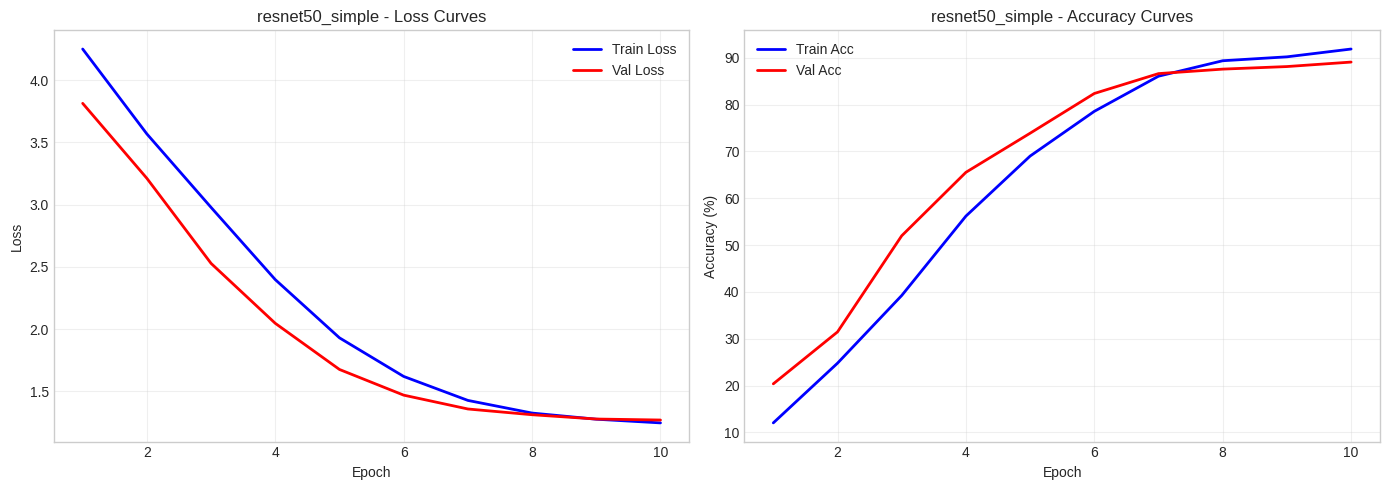


  Best Val Accuracy: 89.06%
  Final Top-5 Accuracy: 96.99%
  Final F1 Score: 0.8771
  Final AUC-ROC: 0.9986
  Training Time: 6.7 min
  Saved to /kaggle/working/models_part1/resnet50_simple_run1.pt

[2/20] Training resnet50 + mlp

Training: resnet50_mlp
Epochs: 10
  Using DataParallel with 2 GPUs


Training resnet50_mlp:   0%|          | 0/10 [00:00<?, ?it/s]

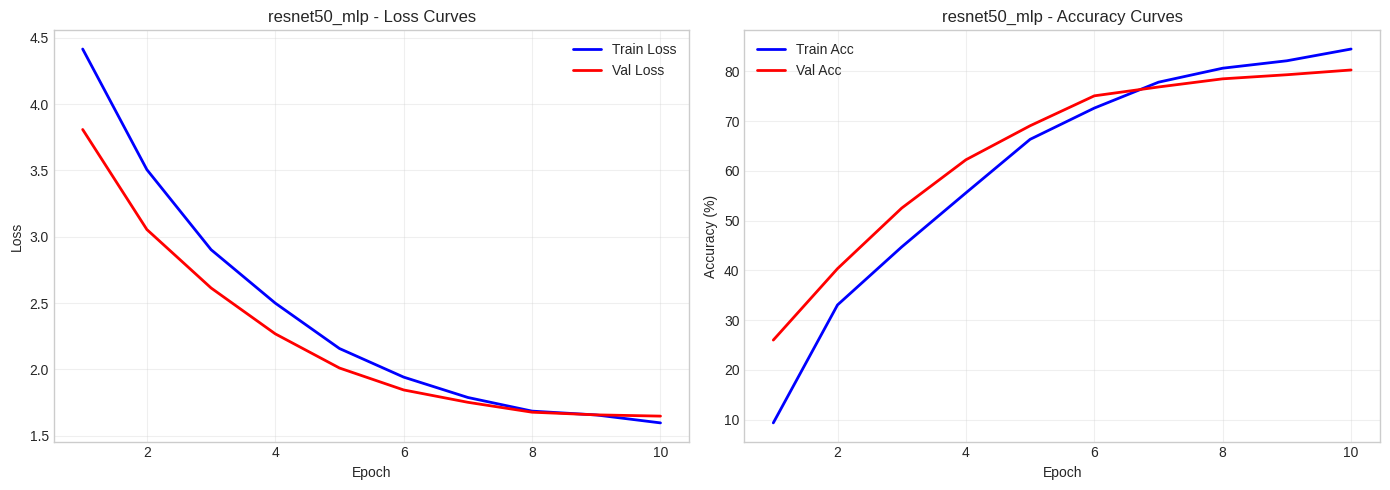


  Best Val Accuracy: 80.30%
  Final Top-5 Accuracy: 95.35%
  Final F1 Score: 0.7628
  Final AUC-ROC: 0.9976
  Training Time: 6.5 min
  Saved to /kaggle/working/models_part1/resnet50_mlp_run1.pt

[3/20] Training resnet50 + deep

Training: resnet50_deep
Epochs: 10
  Using DataParallel with 2 GPUs


Training resnet50_deep:   0%|          | 0/10 [00:00<?, ?it/s]

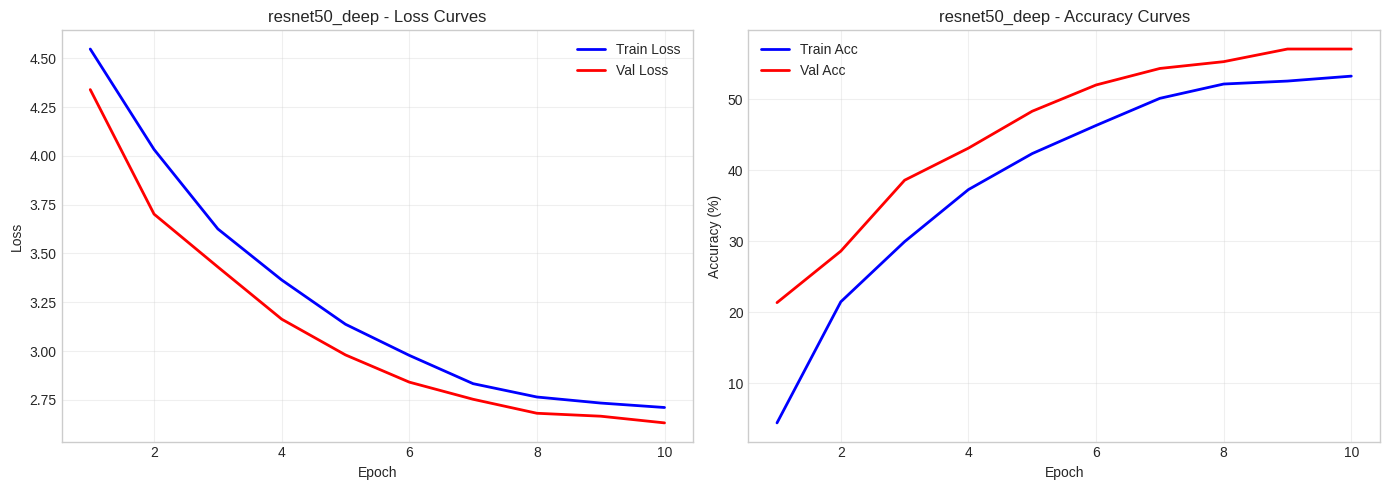


  Best Val Accuracy: 57.05%
  Final Top-5 Accuracy: 77.15%
  Final F1 Score: 0.4698
  Final AUC-ROC: 0.9853
  Training Time: 6.5 min
  Saved to /kaggle/working/models_part1/resnet50_deep_run1.pt

[4/20] Training resnet50 + attention

Training: resnet50_attention
Epochs: 10
  Using DataParallel with 2 GPUs


Training resnet50_attention:   0%|          | 0/10 [00:00<?, ?it/s]

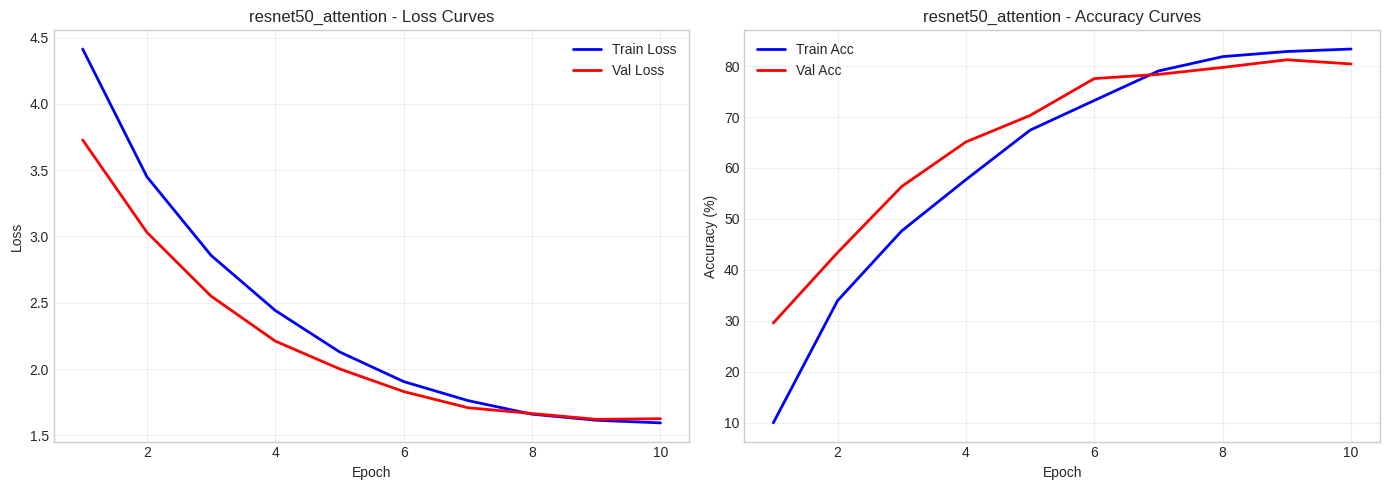


  Best Val Accuracy: 81.26%
  Final Top-5 Accuracy: 94.25%
  Final F1 Score: 0.7652
  Final AUC-ROC: 0.9972
  Training Time: 6.5 min
  Saved to /kaggle/working/models_part1/resnet50_attention_run1.pt

[5/20] Training resnet50 + cosface

Training: resnet50_cosface
Epochs: 10
  Using DataParallel with 2 GPUs


Training resnet50_cosface:   0%|          | 0/10 [00:00<?, ?it/s]

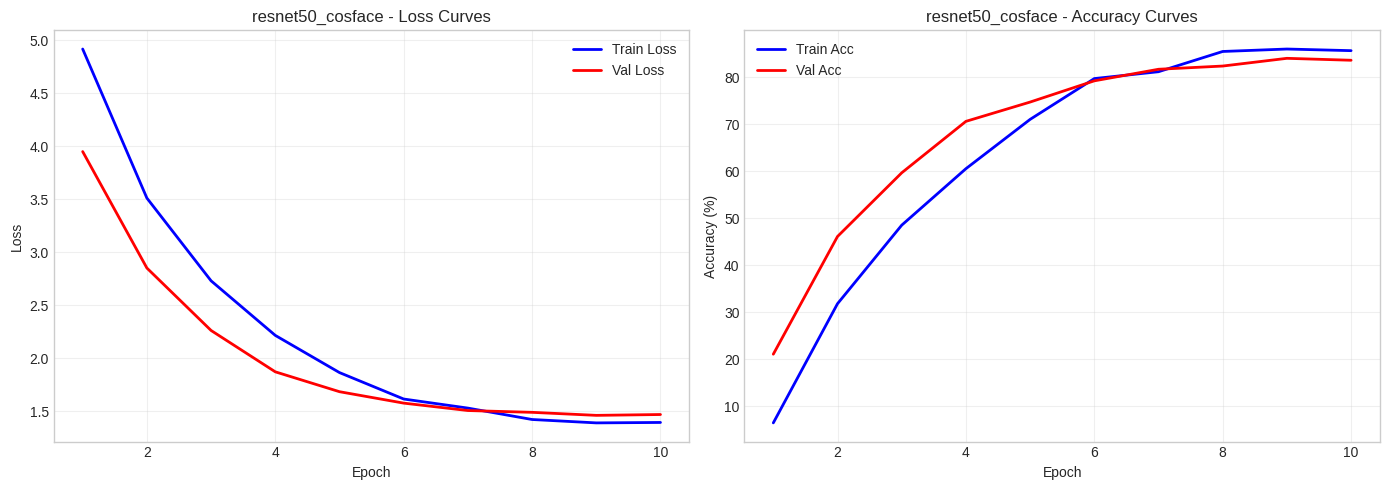


  Best Val Accuracy: 83.99%
  Final Top-5 Accuracy: 95.08%
  Final F1 Score: 0.8228
  Final AUC-ROC: 0.9975
  Training Time: 6.5 min
  Saved to /kaggle/working/models_part1/resnet50_cosface_run1.pt

[6/20] Training efficientnet_b0 + simple

Training: efficientnet_b0_simple
Epochs: 10
  Using DataParallel with 2 GPUs


Training efficientnet_b0_simple:   0%|          | 0/10 [00:00<?, ?it/s]

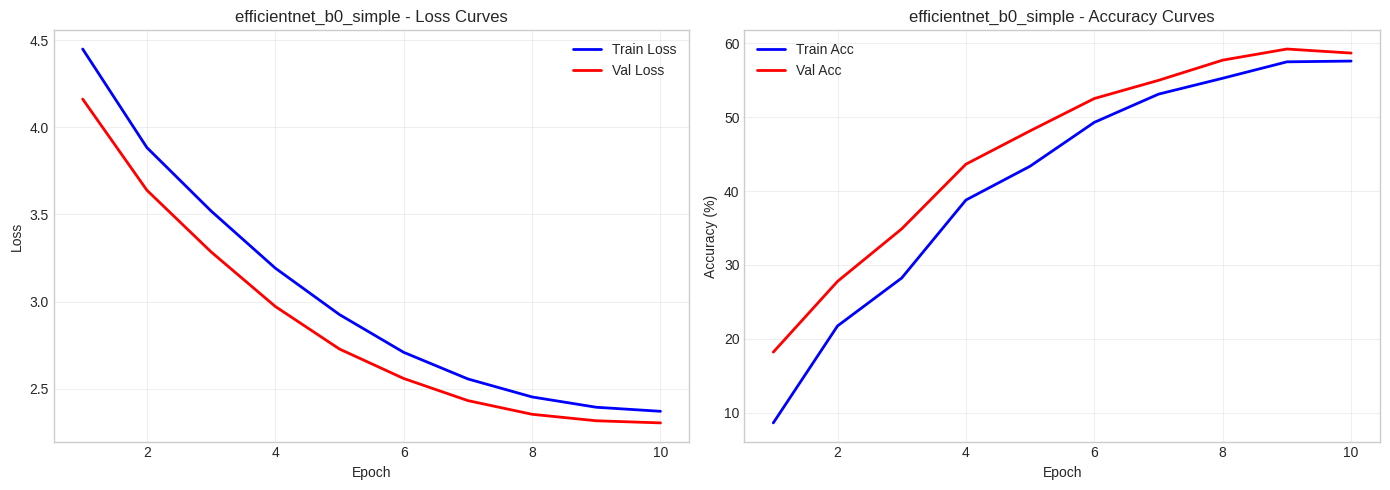


  Best Val Accuracy: 59.23%
  Final Top-5 Accuracy: 81.94%
  Final F1 Score: 0.4904
  Final AUC-ROC: 0.9931
  Training Time: 49.6 min
  Saved to /kaggle/working/models_part1/efficientnet_b0_simple_run1.pt

[7/20] Training efficientnet_b0 + mlp

Training: efficientnet_b0_mlp
Epochs: 10
  Using DataParallel with 2 GPUs


Training efficientnet_b0_mlp:   0%|          | 0/10 [00:00<?, ?it/s]

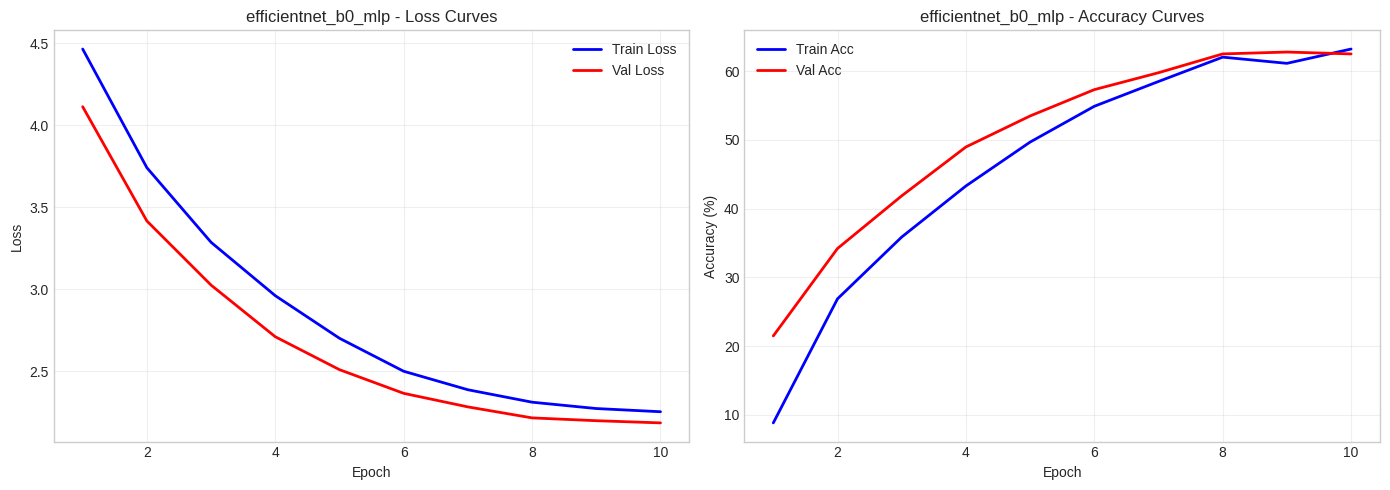


  Best Val Accuracy: 62.79%
  Final Top-5 Accuracy: 85.23%
  Final F1 Score: 0.5317
  Final AUC-ROC: 0.9943
  Training Time: 49.0 min
  Saved to /kaggle/working/models_part1/efficientnet_b0_mlp_run1.pt

[8/20] Training efficientnet_b0 + deep

Training: efficientnet_b0_deep
Epochs: 10
  Using DataParallel with 2 GPUs


Training efficientnet_b0_deep:   0%|          | 0/10 [00:00<?, ?it/s]

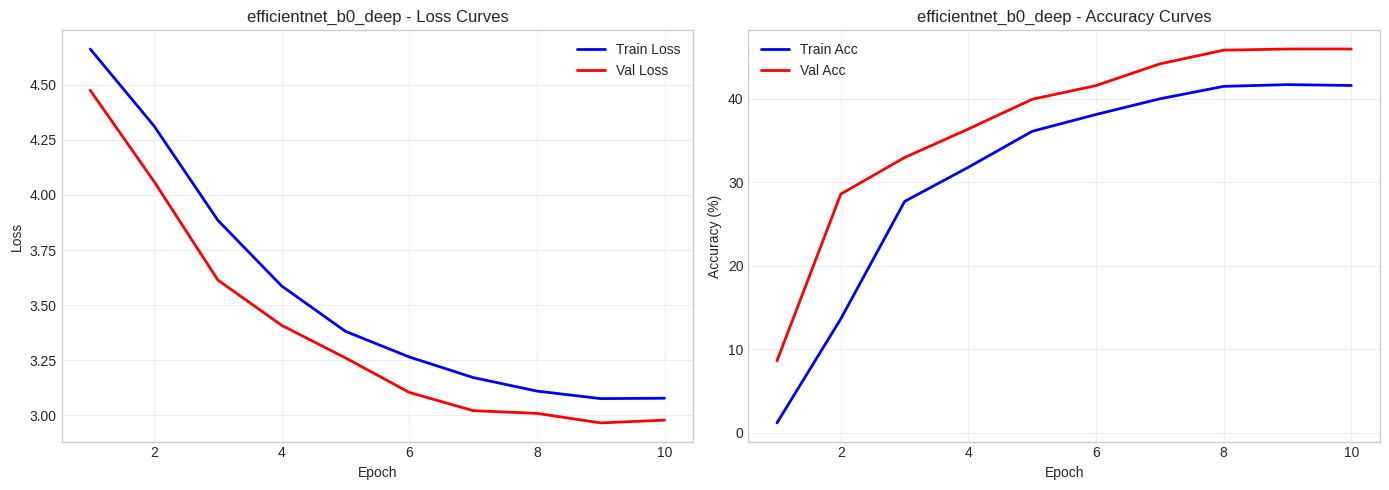


  Best Val Accuracy: 45.96%
  Final Top-5 Accuracy: 68.26%
  Final F1 Score: 0.3399
  Final AUC-ROC: 0.9757
  Training Time: 49.3 min
  Saved to /kaggle/working/models_part1/efficientnet_b0_deep_run1.pt

[9/20] Training efficientnet_b0 + attention

Training: efficientnet_b0_attention
Epochs: 10
  Using DataParallel with 2 GPUs


Training efficientnet_b0_attention:   0%|          | 0/10 [00:00<?, ?it/s]

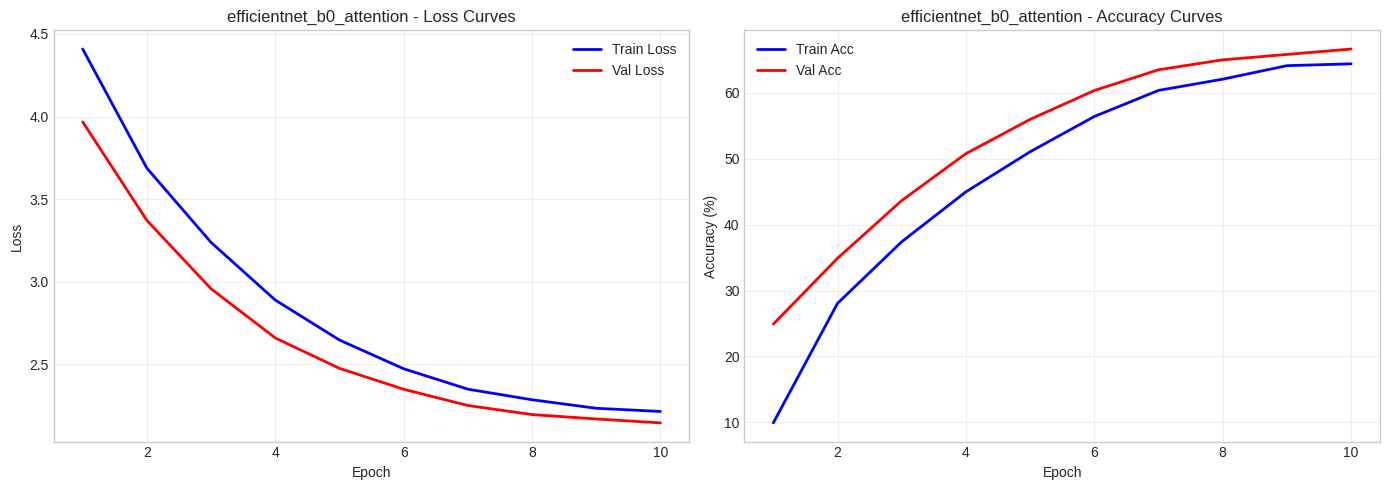


  Best Val Accuracy: 66.62%
  Final Top-5 Accuracy: 84.68%
  Final F1 Score: 0.5893
  Final AUC-ROC: 0.9941
  Training Time: 49.1 min
  Saved to /kaggle/working/models_part1/efficientnet_b0_attention_run1.pt

[10/20] Training efficientnet_b0 + cosface

Training: efficientnet_b0_cosface
Epochs: 10
  Using DataParallel with 2 GPUs


Training efficientnet_b0_cosface:   0%|          | 0/10 [00:00<?, ?it/s]

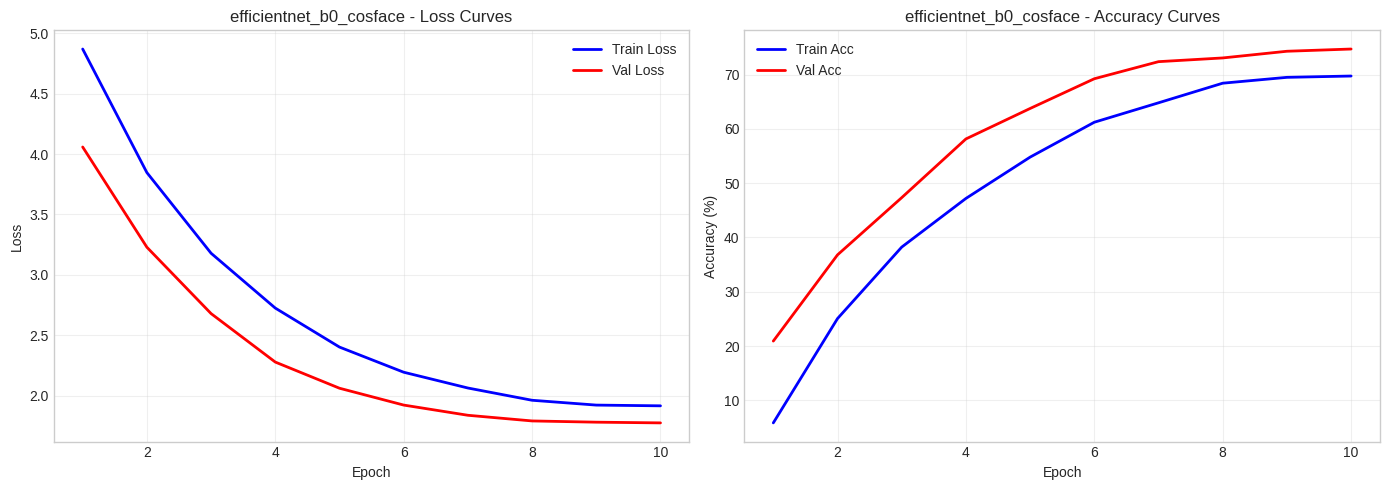


  Best Val Accuracy: 74.69%
  Final Top-5 Accuracy: 89.33%
  Final F1 Score: 0.6999
  Final AUC-ROC: 0.9933
  Training Time: 49.2 min
  Saved to /kaggle/working/models_part1/efficientnet_b0_cosface_run1.pt

[11/20] Training densenet121 + simple

Training: densenet121_simple
Epochs: 10
  Using DataParallel with 2 GPUs


Training densenet121_simple:   0%|          | 0/10 [00:00<?, ?it/s]

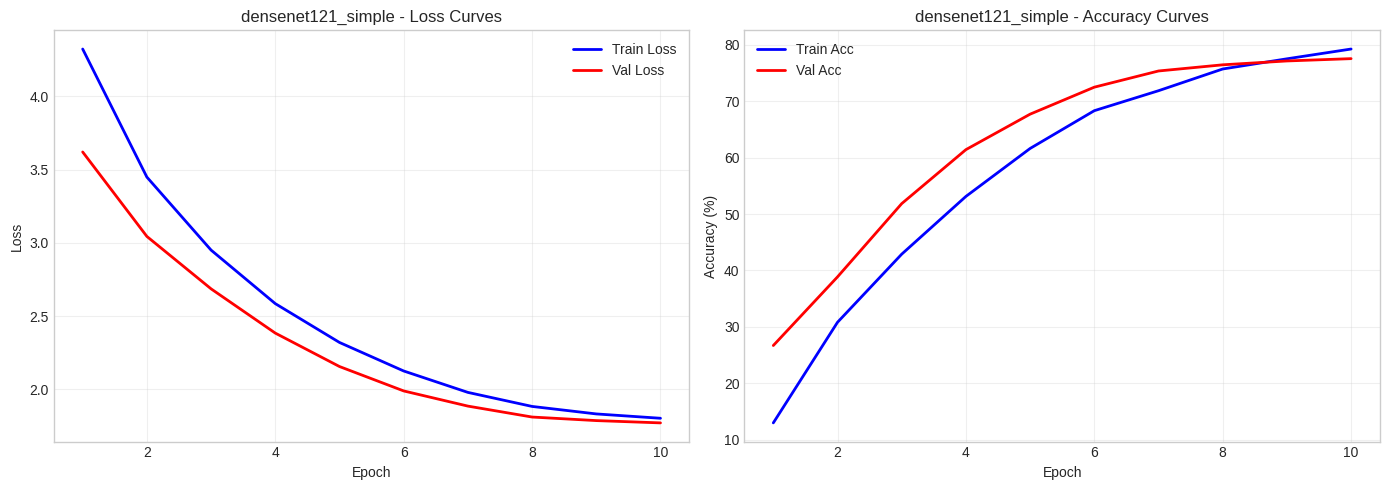


  Best Val Accuracy: 77.56%
  Final Top-5 Accuracy: 93.02%
  Final F1 Score: 0.7214
  Final AUC-ROC: 0.9975
  Training Time: 9.8 min
  Saved to /kaggle/working/models_part1/densenet121_simple_run1.pt

[12/20] Training densenet121 + mlp

Training: densenet121_mlp
Epochs: 10
  Using DataParallel with 2 GPUs


Training densenet121_mlp:   0%|          | 0/10 [00:00<?, ?it/s]

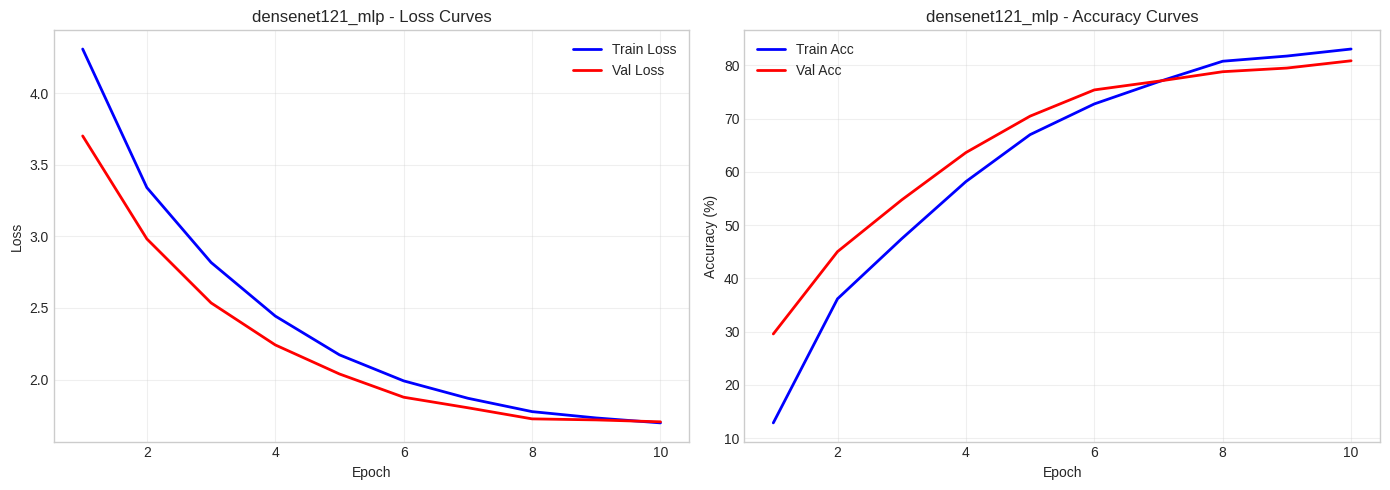


  Best Val Accuracy: 80.85%
  Final Top-5 Accuracy: 93.57%
  Final F1 Score: 0.7647
  Final AUC-ROC: 0.9981
  Training Time: 9.7 min
  Saved to /kaggle/working/models_part1/densenet121_mlp_run1.pt

[13/20] Training densenet121 + deep

Training: densenet121_deep
Epochs: 10
  Using DataParallel with 2 GPUs


Training densenet121_deep:   0%|          | 0/10 [00:00<?, ?it/s]

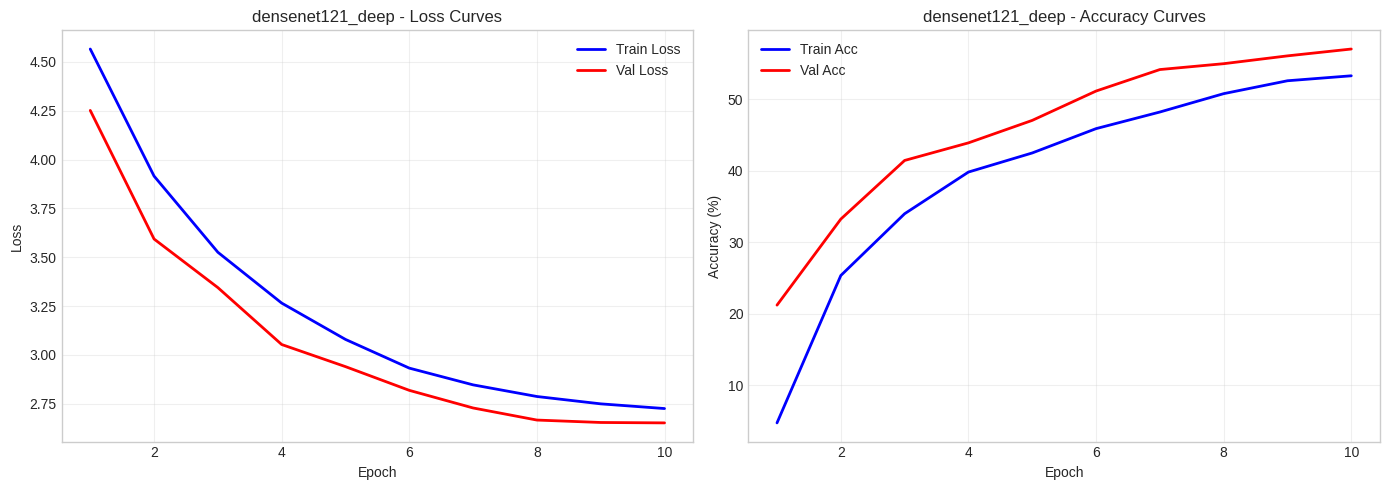


  Best Val Accuracy: 57.05%
  Final Top-5 Accuracy: 76.74%
  Final F1 Score: 0.4781
  Final AUC-ROC: 0.9865
  Training Time: 9.7 min
  Saved to /kaggle/working/models_part1/densenet121_deep_run1.pt

[14/20] Training densenet121 + attention

Training: densenet121_attention
Epochs: 10
  Using DataParallel with 2 GPUs


Training densenet121_attention:   0%|          | 0/10 [00:00<?, ?it/s]

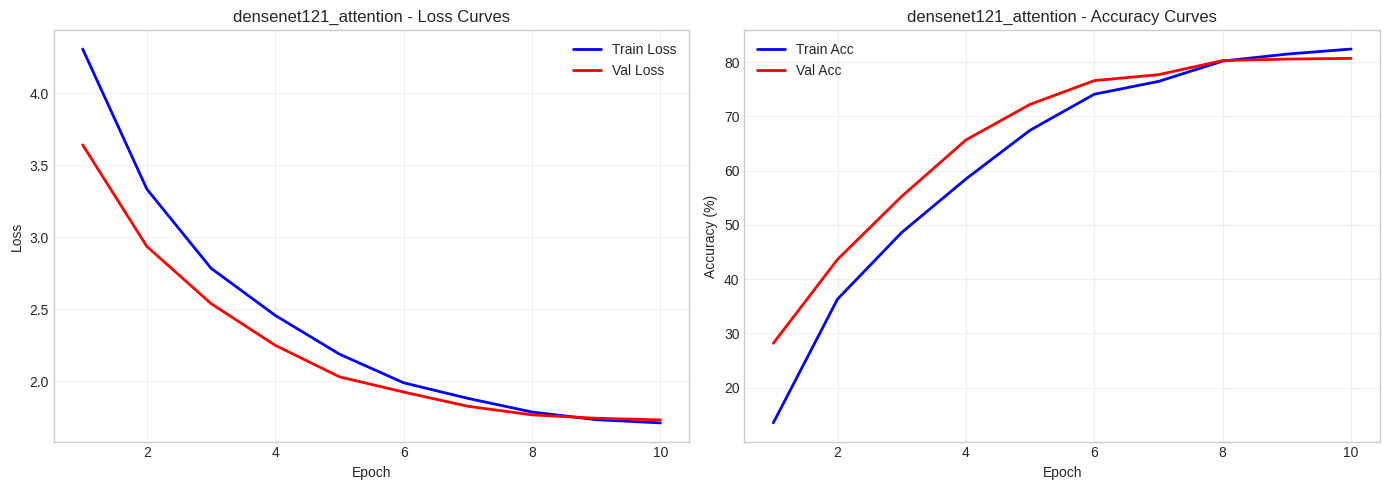


  Best Val Accuracy: 80.71%
  Final Top-5 Accuracy: 93.57%
  Final F1 Score: 0.7667
  Final AUC-ROC: 0.9958
  Training Time: 9.7 min
  Saved to /kaggle/working/models_part1/densenet121_attention_run1.pt

[15/20] Training densenet121 + cosface

Training: densenet121_cosface
Epochs: 10
  Using DataParallel with 2 GPUs


Training densenet121_cosface:   0%|          | 0/10 [00:00<?, ?it/s]

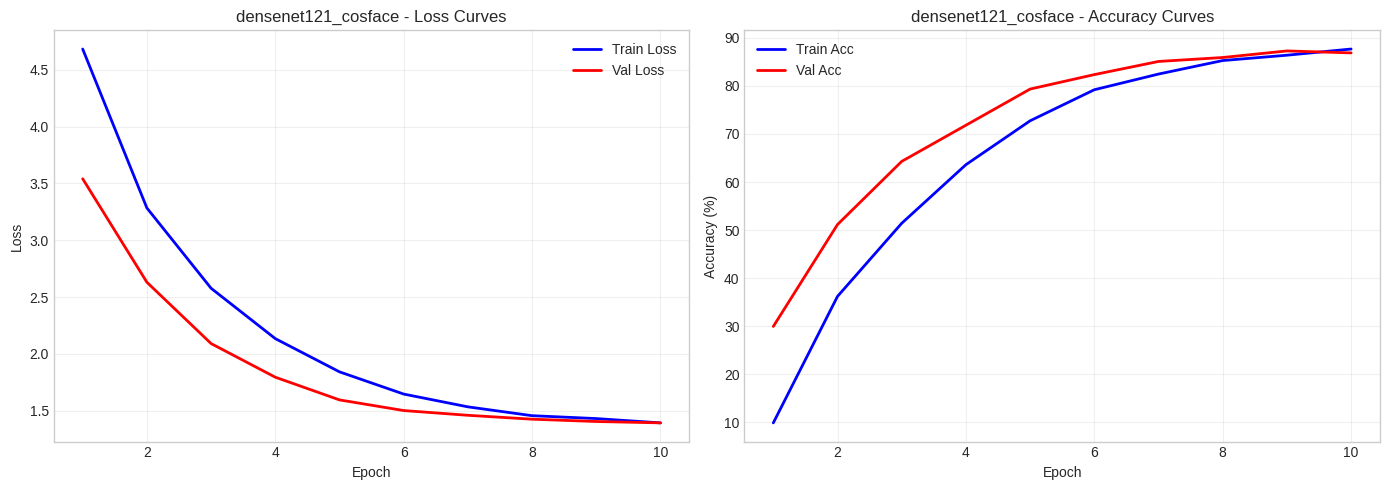


  Best Val Accuracy: 87.28%
  Final Top-5 Accuracy: 96.72%
  Final F1 Score: 0.8527
  Final AUC-ROC: 0.9979
  Training Time: 9.7 min
  Saved to /kaggle/working/models_part1/densenet121_cosface_run1.pt

[16/20] Training mobilenet_v3 + simple

Training: mobilenet_v3_simple
Epochs: 10
  Using DataParallel with 2 GPUs


Training mobilenet_v3_simple:   0%|          | 0/10 [00:00<?, ?it/s]

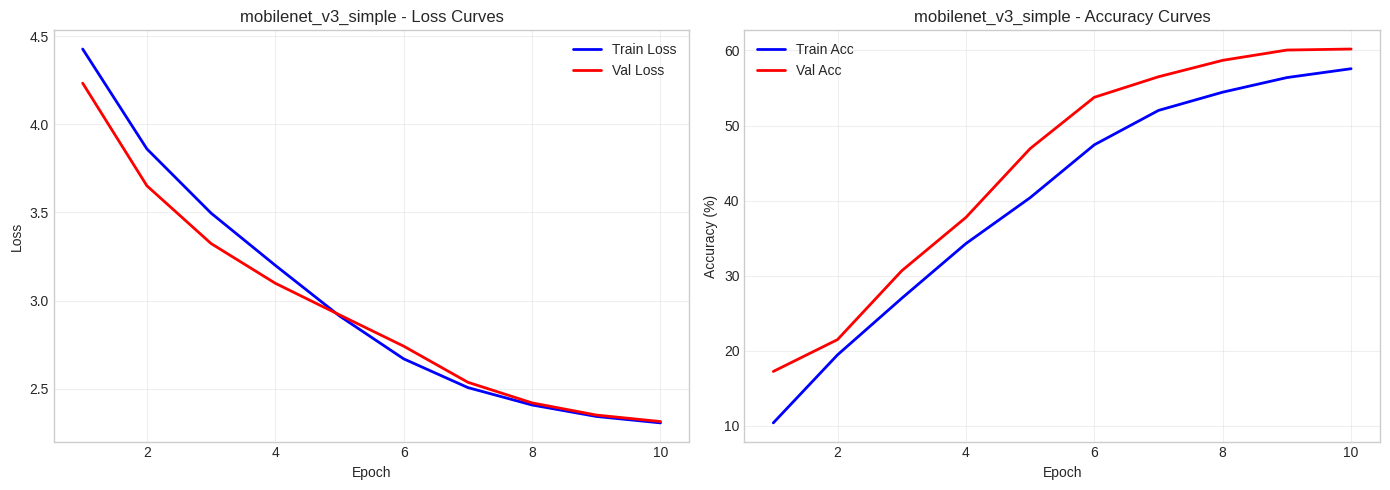


  Best Val Accuracy: 60.19%
  Final Top-5 Accuracy: 82.49%
  Final F1 Score: 0.5074
  Final AUC-ROC: 0.9921
  Training Time: 41.4 min
  Saved to /kaggle/working/models_part1/mobilenet_v3_simple_run1.pt

[17/20] Training mobilenet_v3 + mlp

Training: mobilenet_v3_mlp
Epochs: 10
  Using DataParallel with 2 GPUs


Training mobilenet_v3_mlp:   0%|          | 0/10 [00:00<?, ?it/s]

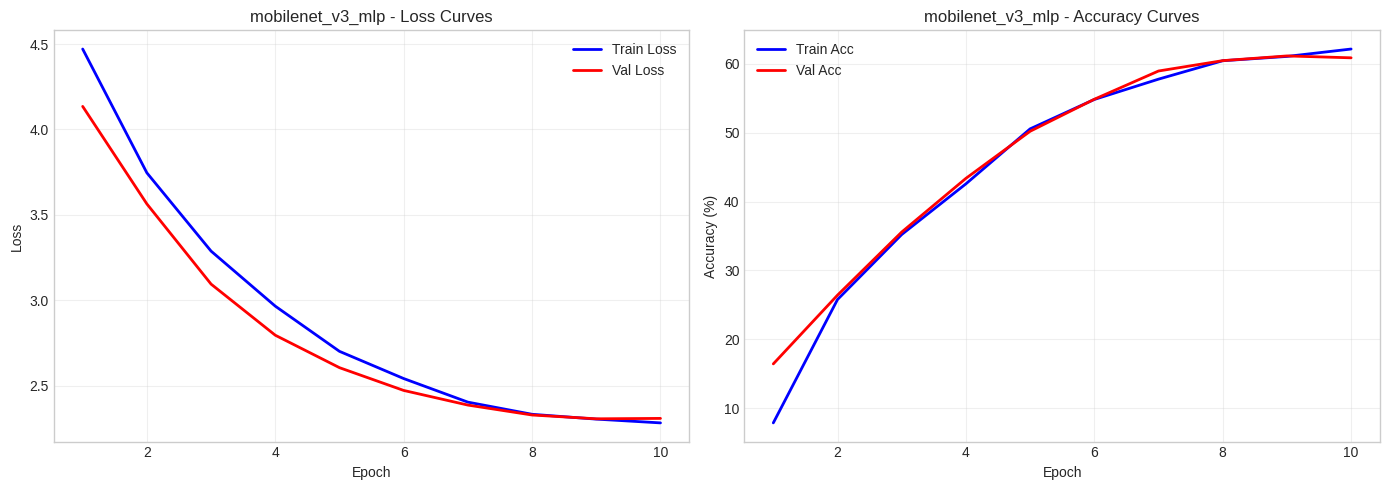


  Best Val Accuracy: 61.15%
  Final Top-5 Accuracy: 80.16%
  Final F1 Score: 0.5180
  Final AUC-ROC: 0.9916
  Training Time: 40.8 min
  Saved to /kaggle/working/models_part1/mobilenet_v3_mlp_run1.pt

[18/20] Training mobilenet_v3 + deep

Training: mobilenet_v3_deep
Epochs: 10
  Using DataParallel with 2 GPUs


Training mobilenet_v3_deep:   0%|          | 0/10 [00:00<?, ?it/s]

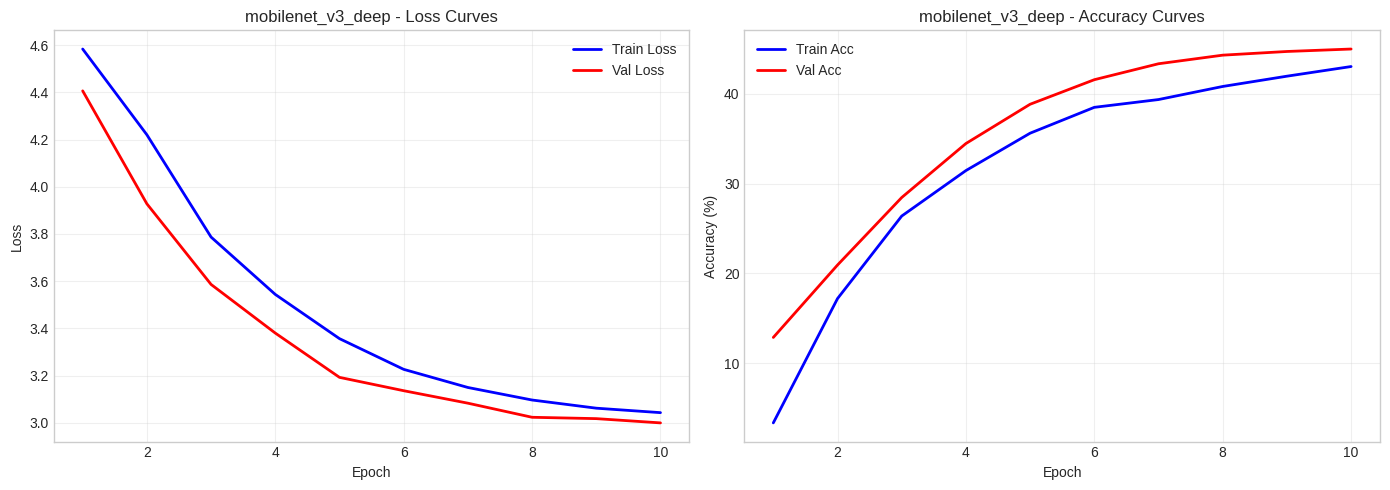


  Best Val Accuracy: 45.01%
  Final Top-5 Accuracy: 69.36%
  Final F1 Score: 0.3342
  Final AUC-ROC: 0.9711
  Training Time: 40.8 min
  Saved to /kaggle/working/models_part1/mobilenet_v3_deep_run1.pt

[19/20] Training mobilenet_v3 + attention

Training: mobilenet_v3_attention
Epochs: 10
  Using DataParallel with 2 GPUs


Training mobilenet_v3_attention:   0%|          | 0/10 [00:00<?, ?it/s]

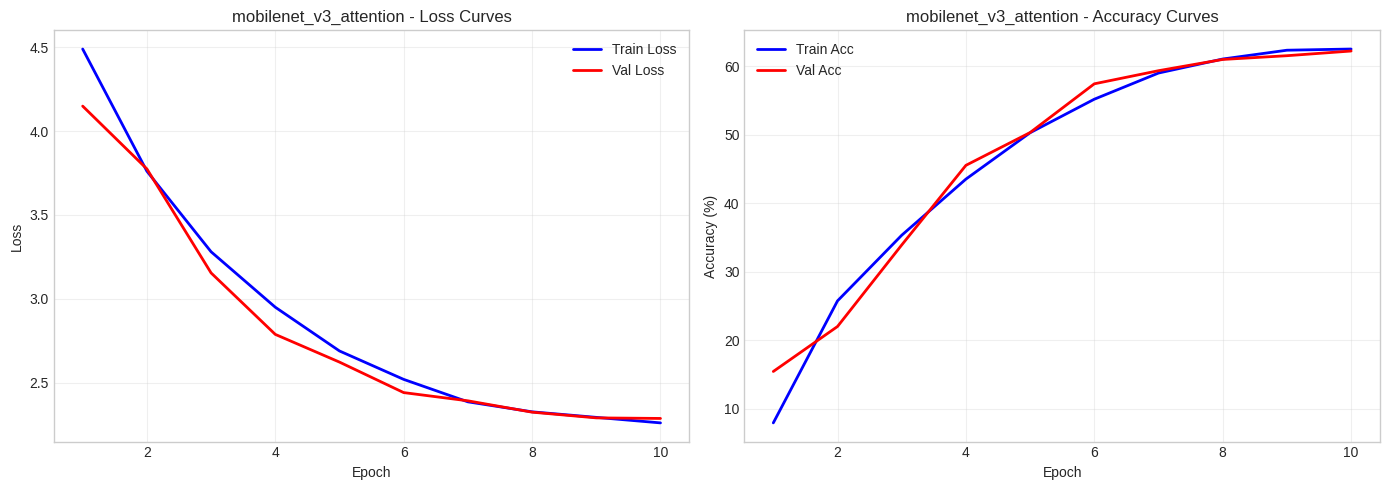


  Best Val Accuracy: 62.24%
  Final Top-5 Accuracy: 83.31%
  Final F1 Score: 0.5275
  Final AUC-ROC: 0.9924
  Training Time: 40.8 min
  Saved to /kaggle/working/models_part1/mobilenet_v3_attention_run1.pt

[20/20] Training mobilenet_v3 + cosface

Training: mobilenet_v3_cosface
Epochs: 10
  Using DataParallel with 2 GPUs


Training mobilenet_v3_cosface:   0%|          | 0/10 [00:00<?, ?it/s]

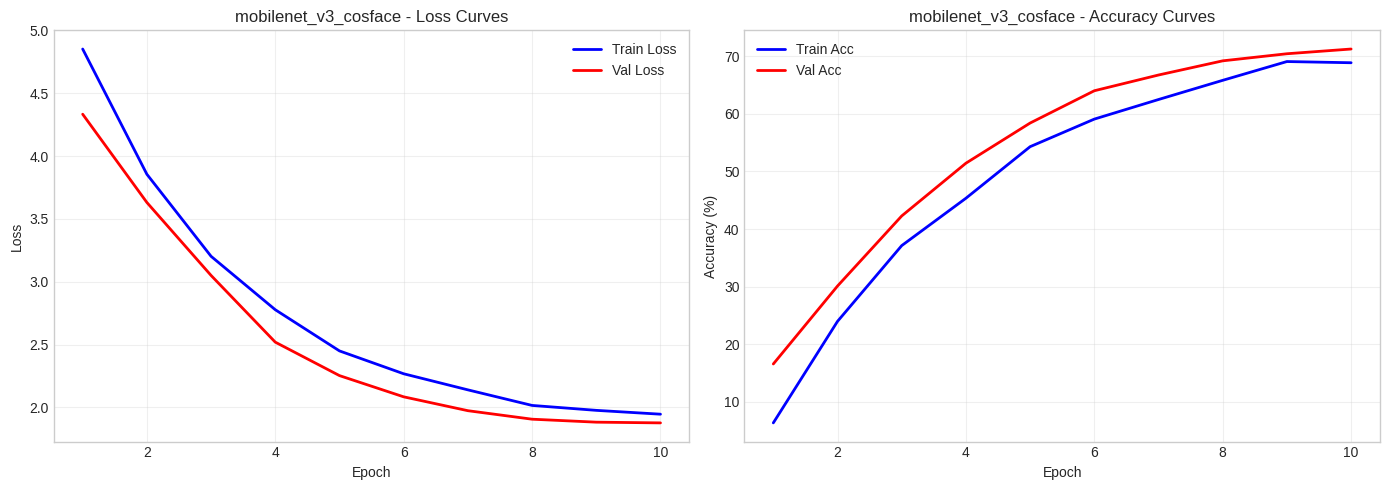


  Best Val Accuracy: 71.27%
  Final Top-5 Accuracy: 88.51%
  Final F1 Score: 0.6613
  Final AUC-ROC: 0.9889
  Training Time: 40.8 min
  Saved to /kaggle/working/models_part1/mobilenet_v3_cosface_run1.pt

Neural Network Training complete! 20 models trained.


In [16]:
# ============================================================
# TRAIN ALL NEURAL NETWORK MODELS (Backbone + Neural Head)
# ============================================================

all_results = {}
all_model_states = {}
backbone_features = {}  # Store extracted features for classical classifiers

current_model = 0

for backbone_name in BACKBONES:
    for head_name in NEURAL_HEADS:
        current_model += 1
        model_key = f"{backbone_name}_{head_name}"
        print(f"\n[{current_model}/{total_neural}] Training {backbone_name} + {head_name}")
        
        try:
            results, model_state = train_model(
                backbone_name=backbone_name,
                head_name=head_name,
                train_loader=train_loader,
                val_loader=val_loader,
                num_classes=num_classes,
                epochs=EPOCHS,  # 10 EPOCHS
                lr=LEARNING_RATE,
                device=device
            )
            
            all_results[model_key] = results
            all_model_states[model_key] = model_state
            
            # Save individual model with systematic naming
            save_path = os.path.join(MODELS_DIR, f"{model_key}_run1.pt")
            torch.save({
                'model_state_dict': model_state,
                'backbone': backbone_name,
                'head': head_name,
                'num_classes': num_classes,
                'class_names': class_names,
                'results': results
            }, save_path)
            print(f"  Saved to {save_path}")
            
        except Exception as e:
            print(f"  ERROR: {str(e)}")
            import traceback
            traceback.print_exc()
            # Memory cleanup on error
            torch.cuda.empty_cache()
            gc.collect()
            continue

print(f"\n{'='*60}")
print(f"Neural Network Training complete! {len(all_results)} models trained.")
print(f"{'='*60}")

## 4.1 Extract Features for Classical Classifiers

In [17]:
# ============================================================
# FEATURE EXTRACTION FOR CLASSICAL CLASSIFIERS
# Extract embeddings from trained backbones for SVM, RF, XGBoost
# ============================================================

def extract_features_from_backbone(backbone_name, train_loader, val_loader, device):
    """Extract features using a trained or pretrained backbone."""
    print(f"\nExtracting features from {backbone_name}...")
    
    # Create backbone model
    backbone, out_features = get_backbone(backbone_name, pretrained=True)
    backbone = backbone.to(device)
    backbone.eval()
    
    if n_gpus > 1:
        backbone = nn.DataParallel(backbone)
    
    train_features = []
    train_labels = []
    val_features = []
    val_labels = []
    
    # Extract training features
    with torch.no_grad():
        for images, labels in tqdm(train_loader, desc=f"  Train features"):
            images = images.to(device, non_blocking=True)
            with autocast(device_type='cuda'):
                features = backbone(images)
                if isinstance(features, tuple):
                    features = features[0]
                # Flatten if needed
                if features.dim() > 2:
                    features = features.view(features.size(0), -1)
            train_features.append(features.cpu().numpy())
            train_labels.extend(labels.numpy())
    
    # Extract validation features
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"  Val features"):
            images = images.to(device, non_blocking=True)
            with autocast(device_type='cuda'):
                features = backbone(images)
                if isinstance(features, tuple):
                    features = features[0]
                if features.dim() > 2:
                    features = features.view(features.size(0), -1)
            val_features.append(features.cpu().numpy())
            val_labels.extend(labels.numpy())
    
    X_train = np.vstack(train_features)
    y_train = np.array(train_labels)
    X_val = np.vstack(val_features)
    y_val = np.array(val_labels)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Save scaler
    scaler_path = os.path.join(MODELS_DIR, f'{backbone_name}_scaler.joblib')
    joblib.dump(scaler, scaler_path)
    
    # Memory cleanup
    del backbone
    torch.cuda.empty_cache()
    gc.collect()
    
    print(f"  Features shape: Train {X_train_scaled.shape}, Val {X_val_scaled.shape}")
    
    return {
        'X_train': X_train_scaled,
        'X_val': X_val_scaled,
        'y_train': y_train,
        'y_val': y_val,
        'scaler_path': scaler_path
    }

# Extract features from all backbones
print(f"\n{'='*60}")
print("EXTRACTING FEATURES FOR CLASSICAL CLASSIFIERS")
print(f"{'='*60}")

for backbone_name in BACKBONES:
    backbone_features[backbone_name] = extract_features_from_backbone(
        backbone_name, train_loader, val_loader, device
    )

print(f"\n{'='*60}")
print("Feature extraction complete!")
print(f"{'='*60}")


EXTRACTING FEATURES FOR CLASSICAL CLASSIFIERS

Extracting features from resnet50...


  Train features:   0%|          | 0/45 [00:00<?, ?it/s]

  Val features:   0%|          | 0/12 [00:00<?, ?it/s]

  Features shape: Train (2880, 2048), Val (731, 2048)

Extracting features from efficientnet_b0...


  Train features:   0%|          | 0/45 [00:00<?, ?it/s]

  Val features:   0%|          | 0/12 [00:00<?, ?it/s]

  Features shape: Train (2880, 1280), Val (731, 1280)

Extracting features from densenet121...


  Train features:   0%|          | 0/45 [00:00<?, ?it/s]

  Val features:   0%|          | 0/12 [00:00<?, ?it/s]

  Features shape: Train (2880, 1024), Val (731, 1024)

Extracting features from mobilenet_v3...


  Train features:   0%|          | 0/45 [00:00<?, ?it/s]

  Val features:   0%|          | 0/12 [00:00<?, ?it/s]

  Features shape: Train (2880, 960), Val (731, 960)

Feature extraction complete!


## 4.2 Train Classical Classifiers (SVM, Random Forest, XGBoost)

In [18]:
# ============================================================
# TRAIN CLASSICAL CLASSIFIERS ON EXTRACTED FEATURES
# SVM (RBF & Linear), Random Forest, XGBoost
# ============================================================

def train_classical_classifier(clf_name, clf_fn, X_train, y_train, X_val, y_val, num_classes):
    """Train and evaluate a classical classifier."""
    print(f"  Training {clf_name}...", end=" ")
    start_time = time.time()
    
    try:
        clf = clf_fn()
        clf.fit(X_train, y_train)
        
        # Training metrics
        train_preds = clf.predict(X_train)
        train_probs = clf.predict_proba(X_train)
        train_acc = accuracy_score(y_train, train_preds) * 100
        
        # Validation metrics
        val_preds = clf.predict(X_val)
        val_probs = clf.predict_proba(X_val)
        val_acc = accuracy_score(y_val, val_preds) * 100
        val_f1 = f1_score(y_val, val_preds, average='weighted')
        val_precision = precision_score(y_val, val_preds, average='weighted')
        val_recall = recall_score(y_val, val_preds, average='weighted')
        
        # Top-5 accuracy
        top5_acc = top_k_accuracy_score(y_val, val_probs, k=min(5, val_probs.shape[1])) * 100
        
        # AUC-ROC
        try:
            y_val_bin = label_binarize(y_val, classes=list(range(num_classes)))
            if y_val_bin.shape[1] > 1:
                auc_score = roc_auc_score(y_val_bin, val_probs, multi_class='ovr', average='weighted')
            else:
                auc_score = 0.0
        except:
            auc_score = 0.0
        
        elapsed = time.time() - start_time
        print(f"Done in {elapsed:.1f}s | Train: {train_acc:.1f}% | Val: {val_acc:.1f}% | AUC: {auc_score:.4f}")
        
        return {
            'train_acc': train_acc,
            'val_acc': val_acc,
            'val_f1': val_f1,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'top5_acc': top5_acc,
            'auc_score': auc_score,
            'train_time': elapsed
        }, clf, val_preds, val_probs
        
    except Exception as e:
        print(f"ERROR: {e}")
        return None, None, None, None

# Store classical classifier results
classical_results = {}
trained_classifiers = {}

current_model = 0

print(f"\n{'='*60}")
print("TRAINING CLASSICAL CLASSIFIERS")
print(f"{'='*60}")

for backbone_name in BACKBONES:
    print(f"\n--- {backbone_name.upper()} Features ---")
    
    feat = backbone_features[backbone_name]
    X_train_feat = feat['X_train']
    X_val_feat = feat['X_val']
    y_train_feat = feat['y_train']
    y_val_feat = feat['y_val']
    
    for clf_name, clf_fn in CLASSICAL_CLASSIFIERS.items():
        current_model += 1
        model_key = f"{backbone_name}_{clf_name}"
        
        metrics, clf, val_preds, val_probs = train_classical_classifier(
            clf_name, clf_fn, X_train_feat, y_train_feat, X_val_feat, y_val_feat, num_classes
        )
        
        if metrics is not None:
            # Store results in same format as neural models
            classical_results[model_key] = {
                'model_name': model_key,
                'backbone': backbone_name,
                'head': clf_name,
                'best_val_acc': metrics['val_acc'],
                'final_val_acc': metrics['val_acc'],
                'final_val_f1': metrics['val_f1'],
                'final_val_top5': metrics['top5_acc'],
                'final_val_auc': metrics['auc_score'],
                'final_train_acc': metrics['train_acc'],
                'val_precision': metrics['val_precision'],
                'val_recall': metrics['val_recall'],
                'train_time': metrics['train_time'],
                'classifier_type': 'classical',
                'history': {
                    'train_loss': [],
                    'train_acc': [metrics['train_acc']],
                    'val_loss': [],
                    'val_acc': [metrics['val_acc']]
                }
            }
            
            trained_classifiers[model_key] = clf
            
            # Save classifier with systematic naming
            clf_path = os.path.join(MODELS_DIR, f"{model_key}_run1.joblib")
            joblib.dump({
                'classifier': clf,
                'backbone': backbone_name,
                'classifier_type': clf_name,
                'num_classes': num_classes,
                'class_names': class_names,
                'scaler_path': feat['scaler_path'],
                'metrics': metrics
            }, clf_path)
        
        # Memory cleanup
        gc.collect()

print(f"\n{'='*60}")
print(f"Classical Classifier Training complete! {len(classical_results)} models trained.")
print(f"{'='*60}")


TRAINING CLASSICAL CLASSIFIERS

--- RESNET50 Features ---
  Training svm_rbf... Done in 143.7s | Train: 66.1% | Val: 21.6% | AUC: 0.8697
  Training svm_linear... Done in 86.3s | Train: 100.0% | Val: 41.6% | AUC: 0.9090
  Training random_forest... Done in 14.5s | Train: 100.0% | Val: 25.9% | AUC: 0.8617
  Training xgboost... Done in 854.6s | Train: 100.0% | Val: 41.2% | AUC: 0.9224

--- EFFICIENTNET_B0 Features ---
  Training svm_rbf... Done in 73.0s | Train: 77.1% | Val: 33.9% | AUC: 0.9228
  Training svm_linear... Done in 40.8s | Train: 100.0% | Val: 54.0% | AUC: 0.9522
  Training random_forest... Done in 18.9s | Train: 100.0% | Val: 31.9% | AUC: 0.8824
  Training xgboost... Done in 476.8s | Train: 100.0% | Val: 43.9% | AUC: 0.9270

--- DENSENET121 Features ---
  Training svm_rbf... Done in 63.8s | Train: 82.3% | Val: 29.7% | AUC: 0.9347
  Training svm_linear... Done in 34.0s | Train: 100.0% | Val: 52.8% | AUC: 0.9575
  Training random_forest... Done in 17.6s | Train: 100.0% | Val: 2

In [19]:
# ============================================================
# MERGE ALL RESULTS (Neural + Classical)
# ============================================================

# Combine neural network and classical classifier results
all_results.update(classical_results)

print(f"\n{'='*60}")
print("ALL MODELS SUMMARY")
print(f"{'='*60}")
print(f"Neural Network Models: {len(all_results) - len(classical_results)}")
print(f"Classical ML Models:   {len(classical_results)}")
print(f"Total Models:          {len(all_results)}")
print(f"{'='*60}")


ALL MODELS SUMMARY
Neural Network Models: 20
Classical ML Models:   16
Total Models:          36


## 5. Results Analysis

In [20]:
# Create results DataFrame (including both neural and classical models)
results_data = []
for name, res in all_results.items():
    results_data.append({
        'Model': name,
        'Backbone': res.get('backbone', 'unknown'),
        'Head': res.get('head', 'unknown'),
        'Type': 'Classical' if res.get('classifier_type') == 'classical' else 'Neural',
        'Train Acc': res.get('final_train_acc', 0),
        'Val Acc': res.get('final_val_acc', 0),
        'Best Val Acc': res.get('best_val_acc', 0),
        'Val F1': res.get('final_val_f1', 0),
        'Top-5 Acc': res.get('final_val_top5', 0),
        'AUC-ROC': res.get('final_val_auc', 0)
    })

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('Best Val Acc', ascending=False)

print("\n" + "="*80)
print("ALL MODELS RANKED BY VALIDATION ACCURACY")
print("="*80)
display(results_df.style.highlight_max(subset=['Train Acc', 'Val Acc', 'Best Val Acc', 'Val F1', 'Top-5 Acc', 'AUC-ROC'])
        .format(precision=2))


ALL MODELS RANKED BY VALIDATION ACCURACY


,Model,Backbone,Head,Type,Train Acc,Val Acc,Best Val Acc,Val F1,Top-5 Acc,AUC-ROC
0,resnet50_simple,resnet50,simple,Neural,91.84,89.06,89.06,0.88,96.99,1.00
14,densenet121_cosface,densenet121,cosface,Neural,87.67,86.87,87.28,0.85,96.72,1.00
4,resnet50_cosface,resnet50,cosface,Neural,85.62,83.58,83.99,0.82,95.08,1.00
3,resnet50_attention,resnet50,attention,Neural,83.37,80.44,81.26,0.77,94.25,1.00
11,densenet121_mlp,densenet121,mlp,Neural,83.06,80.85,80.85,0.76,93.57,1.00
13,densenet121_attention,densenet121,attention,Neural,82.43,80.71,80.71,0.77,93.57,1.00
1,resnet50_mlp,resnet50,mlp,Neural,84.51,80.30,80.30,0.76,95.35,1.00
10,densenet121_simple,densenet121,simple,Neural,79.27,77.56,77.56,0.72,93.02,1.00
9,efficientnet_b0_cosface,efficientnet_b0,cosface,Neural,69.72,74.69,74.69,0.70,89.33,0.99
19,mobilenet_v3_cosface,mobilenet_v3,cosface,Neural,68.89,71.27,71.27,0.66,88.51,0.99


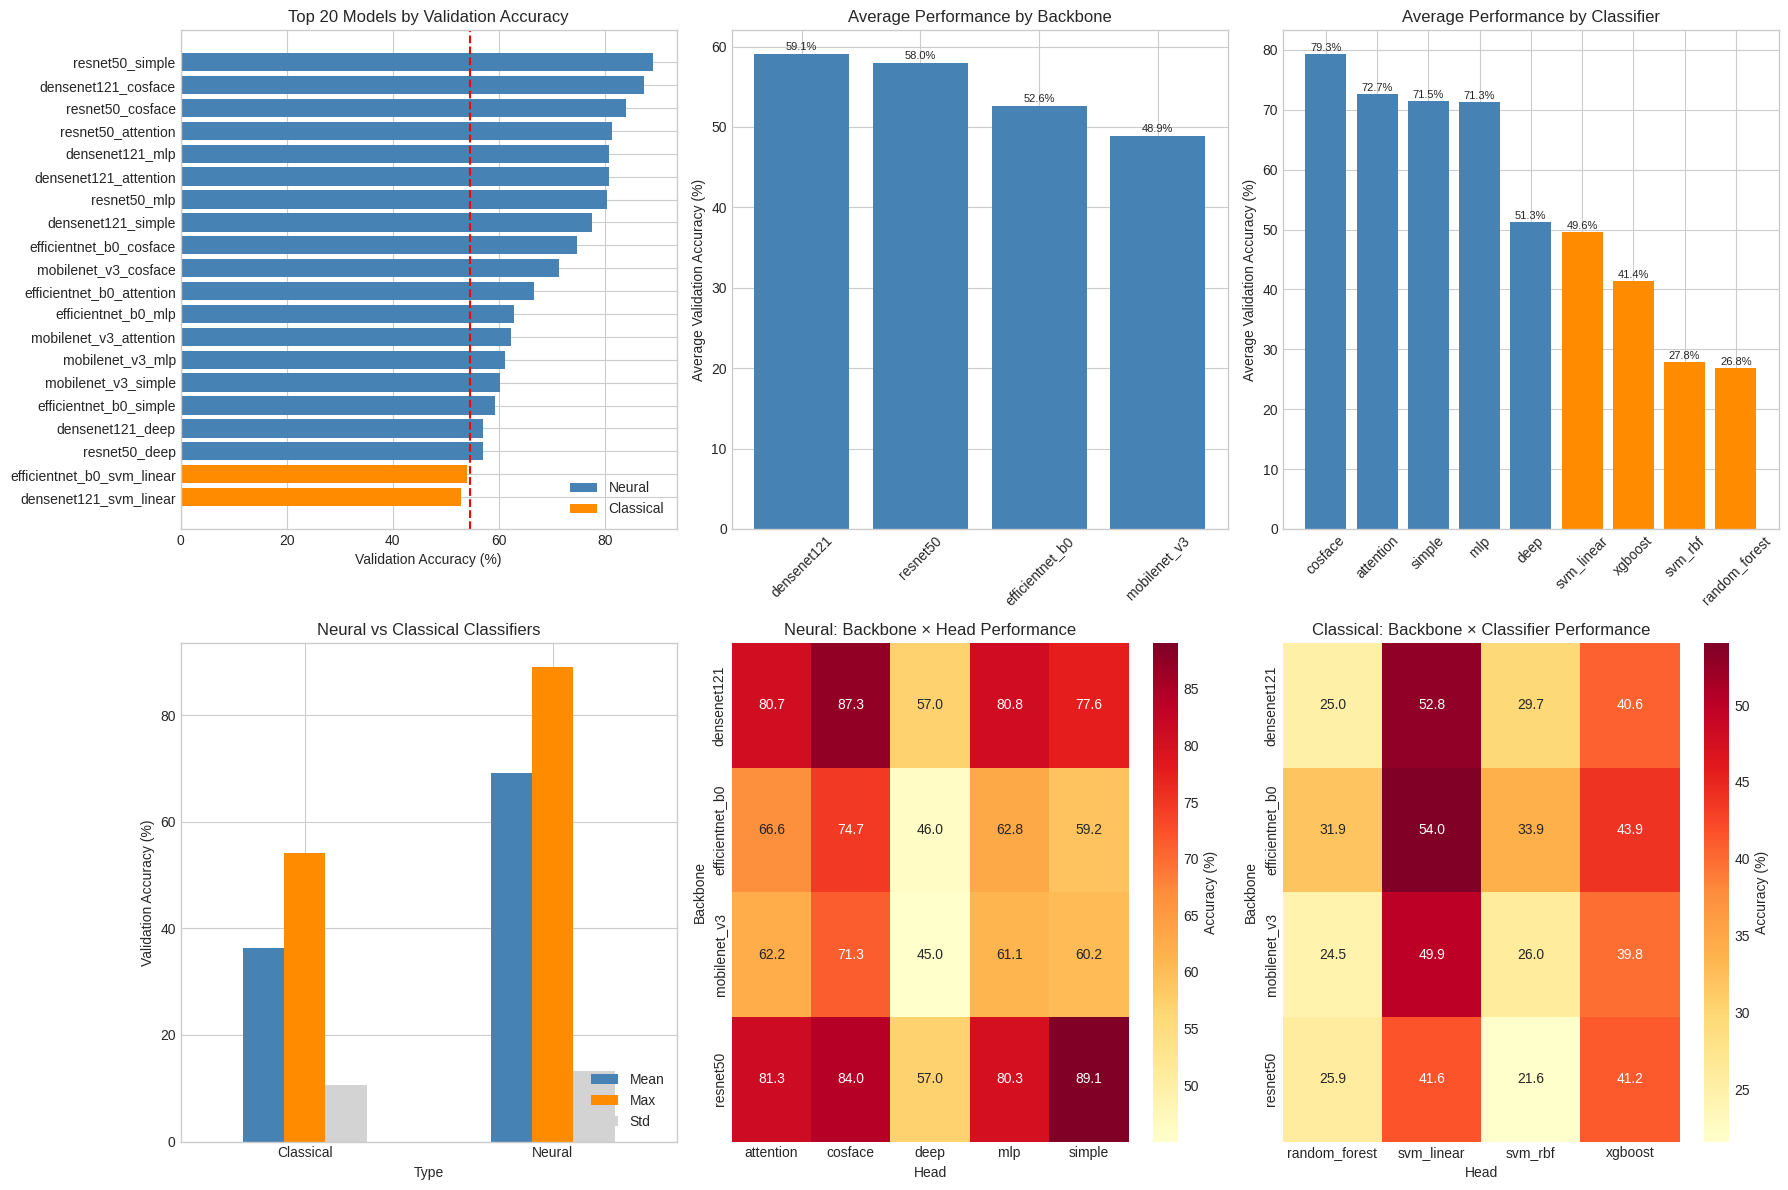

In [21]:
# Visualize results (including classical classifiers)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Validation Accuracy by Model (Top 20)
ax = axes[0, 0]
top_20 = results_df.head(20).sort_values('Best Val Acc', ascending=True)
colors = ['darkorange' if t == 'Classical' else 'steelblue' for t in top_20['Type']]
ax.barh(top_20['Model'], top_20['Best Val Acc'], color=colors)
ax.set_xlabel('Validation Accuracy (%)')
ax.set_title('Top 20 Models by Validation Accuracy')
ax.axvline(results_df['Best Val Acc'].mean(), color='red', linestyle='--', label='Mean')
# Legend for model types
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='steelblue', label='Neural'),
                   Patch(facecolor='darkorange', label='Classical')]
ax.legend(handles=legend_elements, loc='lower right')

# 2. Backbone Comparison
ax = axes[0, 1]
backbone_avg = results_df.groupby('Backbone')['Best Val Acc'].mean().sort_values(ascending=False)
ax.bar(backbone_avg.index, backbone_avg.values, color='steelblue')
ax.set_ylabel('Average Validation Accuracy (%)')
ax.set_title('Average Performance by Backbone')
ax.tick_params(axis='x', rotation=45)
for i, v in enumerate(backbone_avg.values):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=8)

# 3. Classifier Head Comparison
ax = axes[0, 2]
head_avg = results_df.groupby('Head')['Best Val Acc'].mean().sort_values(ascending=False)
colors = ['darkorange' if h in ['svm_rbf', 'svm_linear', 'random_forest', 'xgboost'] else 'steelblue' 
          for h in head_avg.index]
ax.bar(head_avg.index, head_avg.values, color=colors)
ax.set_ylabel('Average Validation Accuracy (%)')
ax.set_title('Average Performance by Classifier')
ax.tick_params(axis='x', rotation=45)
for i, v in enumerate(head_avg.values):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=8)

# 4. Neural vs Classical Comparison
ax = axes[1, 0]
type_comparison = results_df.groupby('Type').agg({
    'Best Val Acc': ['mean', 'max', 'std']
}).round(2)
type_comparison.columns = ['Mean', 'Max', 'Std']
type_comparison.plot(kind='bar', ax=ax, color=['steelblue', 'darkorange', 'lightgray'])
ax.set_title('Neural vs Classical Classifiers')
ax.set_ylabel('Validation Accuracy (%)')
ax.tick_params(axis='x', rotation=0)
ax.legend(loc='lower right')

# 5. Heatmap - Neural Models
ax = axes[1, 1]
neural_df = results_df[results_df['Type'] == 'Neural']
if len(neural_df) > 0:
    pivot_neural = neural_df.pivot(index='Backbone', columns='Head', values='Best Val Acc')
    sns.heatmap(pivot_neural, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax, 
                cbar_kws={'label': 'Accuracy (%)'})
    ax.set_title('Neural: Backbone × Head Performance')
else:
    ax.text(0.5, 0.5, 'No Neural Models', ha='center', va='center')
    ax.set_title('Neural: Backbone × Head Performance')

# 6. Heatmap - Classical Models
ax = axes[1, 2]
classical_df = results_df[results_df['Type'] == 'Classical']
if len(classical_df) > 0:
    pivot_classical = classical_df.pivot(index='Backbone', columns='Head', values='Best Val Acc')
    sns.heatmap(pivot_classical, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax,
                cbar_kws={'label': 'Accuracy (%)'})
    ax.set_title('Classical: Backbone × Classifier Performance')
else:
    ax.text(0.5, 0.5, 'No Classical Models', ha='center', va='center')
    ax.set_title('Classical: Backbone × Classifier Performance')

plt.tight_layout()
plt.savefig(os.path.join(WORK_DIR, 'part1_model_comparison_full.png'), dpi=150)
plt.show()

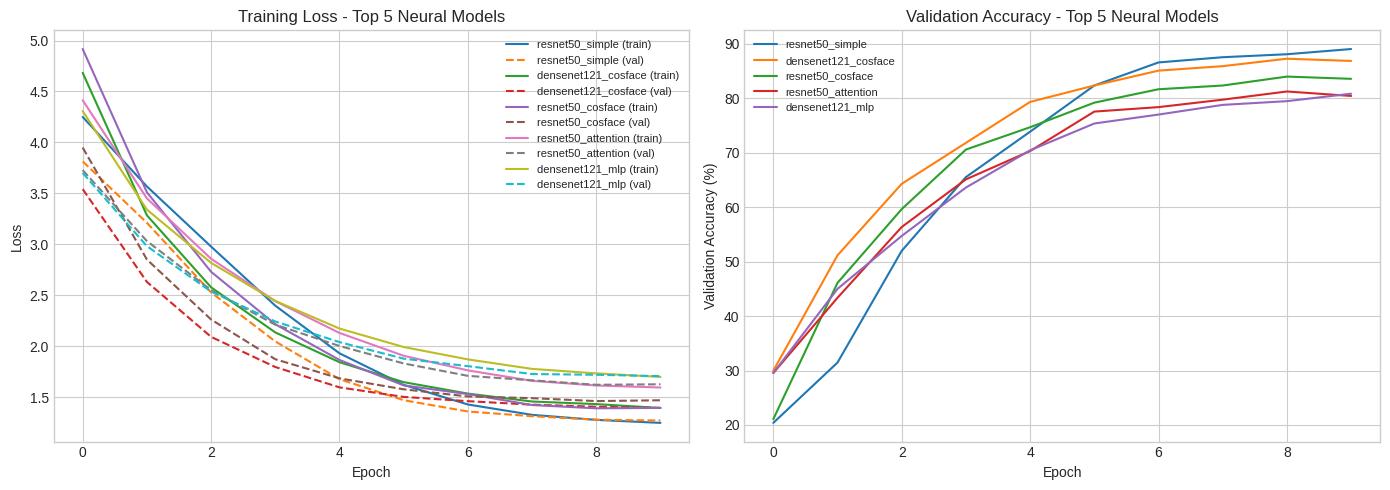

In [22]:
# Training curves for top 5 NEURAL models (classical don't have training curves)
neural_df = results_df[results_df['Type'] == 'Neural']
top_5_neural = neural_df.head(5)['Model'].tolist() if len(neural_df) > 0 else []

if len(top_5_neural) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for model_name in top_5_neural:
        if model_name in all_results:
            history = all_results[model_name].get('history', {})
            if history.get('train_loss'):
                axes[0].plot(history['train_loss'], label=f"{model_name} (train)")
            if history.get('val_loss'):
                axes[0].plot(history['val_loss'], '--', label=f"{model_name} (val)")

    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss - Top 5 Neural Models')
    axes[0].legend(fontsize=8)

    for model_name in top_5_neural:
        if model_name in all_results:
            history = all_results[model_name].get('history', {})
            if history.get('val_acc'):
                axes[1].plot(history['val_acc'], label=model_name)

    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Validation Accuracy (%)')
    axes[1].set_title('Validation Accuracy - Top 5 Neural Models')
    axes[1].legend(fontsize=8)

    plt.tight_layout()
    plt.savefig(os.path.join(WORK_DIR, 'part1_training_curves_top5.png'), dpi=150)
    plt.show()
else:
    print("No neural models with training history to plot.")

In [23]:
# Best model summary (from all models - neural and classical)
best_model_name = results_df.iloc[0]['Model']
best_results = all_results[best_model_name]
best_type = results_df.iloc[0]['Type']

print("\n" + "="*60)
print("BEST MODEL SUMMARY")
print("="*60)
print(f"Model:           {best_model_name}")
print(f"Type:            {best_type}")
print(f"Backbone:        {best_results.get('backbone', 'N/A')}")
print(f"Classifier Head: {best_results.get('head', 'N/A')}")
print(f"")
print(f"Training Accuracy:    {best_results.get('final_train_acc', 0):.2f}%")
print(f"Validation Accuracy:  {best_results.get('best_val_acc', 0):.2f}%")
print(f"Top-5 Accuracy:       {best_results.get('final_val_top5', 0):.2f}%")
print(f"F1 Score:             {best_results.get('final_val_f1', 0):.4f}")
print(f"AUC-ROC:              {best_results.get('final_val_auc', 0):.4f}")
print("="*60)

# Also show best from each category
print("\n" + "="*60)
print("BEST MODEL BY CATEGORY")
print("="*60)

# Best Neural
neural_models = results_df[results_df['Type'] == 'Neural']
if len(neural_models) > 0:
    best_neural = neural_models.iloc[0]
    print(f"\nBest Neural Model: {best_neural['Model']}")
    print(f"  Accuracy: {best_neural['Best Val Acc']:.2f}%")
    print(f"  F1: {best_neural['Val F1']:.4f}")
    print(f"  AUC: {best_neural['AUC-ROC']:.4f}")

# Best Classical
classical_models = results_df[results_df['Type'] == 'Classical']
if len(classical_models) > 0:
    best_classical = classical_models.iloc[0]
    print(f"\nBest Classical Model: {best_classical['Model']}")
    print(f"  Accuracy: {best_classical['Best Val Acc']:.2f}%")
    print(f"  F1: {best_classical['Val F1']:.4f}")
    print(f"  AUC: {best_classical['AUC-ROC']:.4f}")

# Best by Backbone
print("\nBest by Backbone:")
for backbone in BACKBONES:
    backbone_models = results_df[results_df['Backbone'] == backbone]
    if len(backbone_models) > 0:
        best = backbone_models.iloc[0]
        print(f"  {backbone}: {best['Model']} ({best['Best Val Acc']:.2f}%)")

print("="*60)


BEST MODEL SUMMARY
Model:           resnet50_simple
Type:            Neural
Backbone:        resnet50
Classifier Head: simple

Training Accuracy:    91.84%
Validation Accuracy:  89.06%
Top-5 Accuracy:       96.99%
F1 Score:             0.8771
AUC-ROC:              0.9986

BEST MODEL BY CATEGORY

Best Neural Model: resnet50_simple
  Accuracy: 89.06%
  F1: 0.8771
  AUC: 0.9986

Best Classical Model: efficientnet_b0_svm_linear
  Accuracy: 54.04%
  F1: 0.5112
  AUC: 0.9522

Best by Backbone:
  resnet50: resnet50_simple (89.06%)
  efficientnet_b0: efficientnet_b0_cosface (74.69%)
  densenet121: densenet121_cosface (87.28%)
  mobilenet_v3: mobilenet_v3_cosface (71.27%)


## 6. Save Best Model for Video Inference

In [24]:
# Save best model in the format compatible with video inference
best_model_path = os.path.join(MODELS_DIR, 'best_face_recognition.pt')

# Check if best model is neural or classical
is_best_classical = best_results.get('classifier_type') == 'classical'

if is_best_classical:
    # For classical models, save differently
    best_model_path = os.path.join(MODELS_DIR, 'best_face_recognition_classical.joblib')
    
    # Get the trained classifier
    if best_model_name in trained_classifiers:
        best_save_dict = {
            'classifier': trained_classifiers[best_model_name],
            'backbone': best_results['backbone'],
            'classifier_type': best_results['head'],
            'num_classes': num_classes,
            'class_names': class_names,
            'best_val_acc': best_results['best_val_acc'],
            'scaler_path': backbone_features[best_results['backbone']]['scaler_path'],
            'results': best_results
        }
        joblib.dump(best_save_dict, best_model_path)
        print(f"Best classical model saved to: {best_model_path}")
    else:
        print("Warning: Best classical model not found in trained_classifiers")
else:
    # For neural models
    if best_model_name in all_model_states:
        best_save_dict = {
            'model_state_dict': all_model_states[best_model_name],
            'backbone': best_results['backbone'],
            'head': best_results['head'],
            'num_classes': num_classes,
            'class_names': class_names,
            'best_val_acc': best_results['best_val_acc'],
            'results': best_results
        }
        torch.save(best_save_dict, best_model_path)
        print(f"Best neural model saved to: {best_model_path}")
    else:
        print("Warning: Best neural model state not found")

# Also save class names as JSON
class_names_path = os.path.join(MODELS_DIR, 'class_names.json')
with open(class_names_path, 'w') as f:
    json.dump(class_names, f, indent=2)
print(f"Class names saved to: {class_names_path}")

# Save best neural model specifically (for video inference compatibility)
neural_df = results_df[results_df['Type'] == 'Neural']
if len(neural_df) > 0:
    best_neural_name = neural_df.iloc[0]['Model']
    if best_neural_name in all_model_states:
        best_neural_results = all_results[best_neural_name]
        best_neural_path = os.path.join(MODELS_DIR, 'best_neural_face_recognition.pt')
        torch.save({
            'model_state_dict': all_model_states[best_neural_name],
            'backbone': best_neural_results['backbone'],
            'head': best_neural_results['head'],
            'num_classes': num_classes,
            'class_names': class_names,
            'best_val_acc': best_neural_results['best_val_acc'],
            'results': best_neural_results
        }, best_neural_path)
        print(f"Best neural model saved to: {best_neural_path}")

Best neural model saved to: /kaggle/working/models_part1/best_face_recognition.pt
Class names saved to: /kaggle/working/models_part1/class_names.json
Best neural model saved to: /kaggle/working/models_part1/best_neural_face_recognition.pt


In [25]:
# ============================================================
# SAVE ALL RESULTS AS JSON
# ============================================================

json_output = []

for model_key, metrics in all_results.items():
    # Get history
    history = metrics.get('history', {})
    
    # Determine if this is a neural or classical model
    is_classical = metrics.get('classifier_type') == 'classical'
    
    model_data = {
        'model_name': model_key,
        'backbone': metrics.get('backbone', 'unknown'),
        'classifier': metrics.get('head', 'unknown'),
        'classifier_type': 'classical' if is_classical else 'neural',
        'epochs': len(history.get('train_loss', [])) if not is_classical else 0,
        'backbone_training': {
            'train_loss': history.get('train_loss', []),
            'val_loss': history.get('val_loss', []),
            'train_accuracy': history.get('train_acc', []),
            'val_accuracy': history.get('val_acc', [])
        },
        'classifier_metrics': {
            'train_accuracy': float(metrics.get('final_train_acc', 0.0)),
            'test_accuracy': float(metrics.get('final_val_acc', 0.0)),
            'best_accuracy': float(metrics.get('best_val_acc', 0.0)),
            'precision': float(metrics.get('val_precision', 0.0)) if is_classical else 0.0,
            'recall': float(metrics.get('val_recall', 0.0)) if is_classical else 0.0,
            'f1': float(metrics.get('final_val_f1', 0.0)),
            'top5_accuracy': float(metrics.get('final_val_top5', 0.0)),
            'auc_roc': float(metrics.get('final_val_auc', 0.0))
        }
    }
    
    # Add training time for classical classifiers
    if is_classical:
        model_data['training_time_seconds'] = float(metrics.get('train_time', 0.0))
    else:
        model_data['training_time_seconds'] = float(metrics.get('training_time', 0.0))
    
    json_output.append(model_data)

# Sort by test accuracy
json_output = sorted(json_output, key=lambda x: x['classifier_metrics']['test_accuracy'], reverse=True)

# Save to JSON file
output_file = os.path.join(WORK_DIR, 'part1_model_results.json')
with open(output_file, 'w') as f:
    json.dump(json_output, f, indent=4)

print(f"\n{'='*60}")
print("JSON RESULTS SAVED")
print(f"{'='*60}")
print(f"Results saved to: {output_file}")
print(f"Total models saved: {len(json_output)}")
print(f"\nTop 5 Models by Validation Accuracy:")
for i, model in enumerate(json_output[:5], 1):
    print(f"  {i}. {model['model_name']}: {model['classifier_metrics']['test_accuracy']:.2f}% | F1: {model['classifier_metrics']['f1']:.4f} | AUC: {model['classifier_metrics']['auc_roc']:.4f}")
print(f"{'='*60}")


JSON RESULTS SAVED
Results saved to: /kaggle/working/part1_model_results.json
Total models saved: 36

Top 5 Models by Validation Accuracy:
  1. resnet50_simple: 89.06% | F1: 0.8771 | AUC: 0.9986
  2. densenet121_cosface: 86.87% | F1: 0.8527 | AUC: 0.9979
  3. resnet50_cosface: 83.58% | F1: 0.8228 | AUC: 0.9975
  4. densenet121_mlp: 80.85% | F1: 0.7647 | AUC: 0.9981
  5. densenet121_attention: 80.71% | F1: 0.7667 | AUC: 0.9958


In [26]:
print("\n" + "="*60)
print("PART 1 TRAINING COMPLETE!")
print("="*60)

# Count models by type
neural_count = len([r for r in all_results.values() if r.get('classifier_type') != 'classical'])
classical_count = len([r for r in all_results.values() if r.get('classifier_type') == 'classical'])

print(f"\nTotal models trained: {len(all_results)}")
print(f"  - Neural Network models: {neural_count}")
print(f"  - Classical ML models:   {classical_count}")
print(f"\nBackbones used: {BACKBONES}")
print(f"Neural heads:   {NEURAL_HEADS}")
print(f"Classical:      {list(CLASSICAL_CLASSIFIERS.keys())}")

print(f"\nBest overall model: {best_model_name}")
print(f"Best accuracy: {best_results.get('best_val_acc', 0):.2f}%")
print(f"Best F1 Score: {best_results.get('final_val_f1', 0):.4f}")
print(f"Best AUC-ROC: {best_results.get('final_val_auc', 0):.4f}")

print(f"\nFiles saved:")
print(f"  - Best model: {best_model_path}")
print(f"  - Class names: {class_names_path}")
print(f"  - All results (JSON): {os.path.join(WORK_DIR, 'part1_model_results.json')}")
print(f"  - Individual models in: {MODELS_DIR}/")
print(f"\nModel naming convention: <backbone>_<classifier>_run1.pt/.joblib")
print("="*60)


PART 1 TRAINING COMPLETE!

Total models trained: 36
  - Neural Network models: 20
  - Classical ML models:   16

Backbones used: ['resnet50', 'efficientnet_b0', 'densenet121', 'mobilenet_v3']
Neural heads:   ['simple', 'mlp', 'deep', 'attention', 'cosface']
Classical:      ['svm_rbf', 'svm_linear', 'random_forest', 'xgboost']

Best overall model: resnet50_simple
Best accuracy: 89.06%
Best F1 Score: 0.8771
Best AUC-ROC: 0.9986

Files saved:
  - Best model: /kaggle/working/models_part1/best_face_recognition.pt
  - Class names: /kaggle/working/models_part1/class_names.json
  - All results (JSON): /kaggle/working/part1_model_results.json
  - Individual models in: /kaggle/working/models_part1/

Model naming convention: <backbone>_<classifier>_run1.pt/.joblib
